In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.impute import KNNImputer
!pip install shap

In [3]:
df=pd.read_csv('aiclub.csv')
df

,school,sex,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,famrel,freetime,goout,Dalc,health,absences,G1,G2,G3,Feature_1,Feature_2,Feature_3,romantic
0,GP,F,U,GT3,A,4,4.0,at_home,teacher,course,mother,2.0,0,yes,no,no,no,yes,yes,no,4,3.0,4,1,3,4.0,0,11.0,11,18.0,2.0,1.0,no
1,GP,F,U,GT3,T,1,1.0,at_home,other,course,father,NaN,0,no,yes,no,no,no,yes,yes,5,3.0,3,1,3,2.0,9,11.0,11,17.0,2.0,1.0,no
2,GP,F,U,LE3,T,1,1.0,at_home,other,other,mother,1.0,0,yes,no,no,no,yes,yes,yes,4,3.0,2,2,3,6.0,12,13.0,12,15.0,NaN,3.0,no
3,GP,F,U,GT3,T,4,2.0,health,services,home,mother,1.0,0,no,yes,no,yes,yes,yes,yes,3,2.0,2,1,5,0.0,14,14.0,14,15.0,3.0,1.0,yes
4,GP,F,U,GT3,T,3,3.0,other,other,home,father,1.0,0,no,yes,no,no,yes,yes,no,4,3.0,2,1,5,0.0,11,13.0,13,16.0,NaN,2.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,R,GT3,T,2,3.0,services,other,course,mother,1.0,1,no,no,no,yes,no,yes,yes,5,4.0,2,1,5,4.0,10,11.0,10,19.0,3.0,2.0,no
645,MS,F,U,LE3,T,3,1.0,teacher,services,course,mother,1.0,0,no,yes,no,no,yes,NaN,yes,4,NaN,4,1,1,NaN,15,15.0,16,18.0,2.0,1.0,no
646,MS,F,U,GT3,T,1,1.0,other,other,course,mother,2.0,0,no,no,no,yes,yes,yes,no,1,1.0,1,1,5,6.0,11,12.0,9,18.0,NaN,1.0,no
647,MS,M,U,LE3,T,3,1.0,services,services,course,mother,2.0,0,no,no,no,no,no,yes,yes,2,4.0,5,3,2,6.0,10,10.0,10,NaN,1.0,4.0,no


In [4]:
null_col=df.isnull().sum()
null_col=null_col[null_col>0]
null_col

,0
famsize,50
Fedu,73
traveltime,73
higher,76
freetime,45
absences,69
G2,35
Feature_1,38
Feature_2,46
Feature_3,39


In [5]:
df['sex'].value_counts()

,count
sex,
F,383
M,266


In [6]:
df['guardian'].value_counts()

,count
guardian,
mother,455
father,153
other,41


In [7]:
#  as Guardian are others so i need to use dummy else i can use 0 and 1 for male and female respectively
df = pd.get_dummies(df, columns=['guardian'], prefix='gaurdian', drop_first=True)

In [8]:
# encoding Sex column
df['sex']=df['sex'].map({"F":1,"M":0})

In [9]:
#  as together P status is more powerfull : A general intution
df['Pstatus']=df['Pstatus'].map({'A':0,'T':1})

In [10]:
#  as we can not guess a general,so it depend on popularity of school
df["school"].value_counts()
gp=423/(423+226)
ms=226/(226+423)
df['school']=df['school'].map({'GP': gp, 'MS': ms})

In [11]:
print(df['address'].value_counts())
#  As Urban are more strong (interms of lifestyle )
df['address']=df['address'].map({'U': 1, 'R': 0})

address
U    452
R    197
Name: count, dtype: int64


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   school           649 non-null    float64
 1   sex              649 non-null    int64  
 2   address          649 non-null    int64  
 3   famsize          599 non-null    object 
 4   Pstatus          649 non-null    int64  
 5   Medu             649 non-null    int64  
 6   Fedu             576 non-null    float64
 7   Mjob             649 non-null    object 
 8   Fjob             649 non-null    object 
 9   reason           649 non-null    object 
 10  traveltime       576 non-null    float64
 11  failures         649 non-null    int64  
 12  schoolsup        649 non-null    object 
 13  famsup           649 non-null    object 
 14  paid             649 non-null    object 
 15  activities       649 non-null    object 
 16  nursery          649 non-null    object 
 17  higher          

In [13]:
binary_col = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [14]:
for col in binary_col:
    df[col] = df[col].map({'yes': 1, 'no': 0})

In [15]:
#  If Parents are together then size will be greater than 3 and if not then less genrally
df.loc[df['famsize'].isna() & (df['Pstatus'] == 0), 'famsize'] = 'LE3'
df.loc[df['famsize'].isna() & (df['Pstatus'] == 1), 'famsize'] = 'GT3'
df["famsize"]=df["famsize"].map({"LE3": 2, "GT3": 4})

In [16]:
df.Fjob.unique()

array(['teacher', 'other', 'services', 'health', 'at_home'], dtype=object)

In [17]:
Fedu_Job=df.groupby(['Fjob'])["Fedu"].mean().to_dict
print(Fedu_Job)
cross_table_fjob_fedu = pd.crosstab(df['Fjob'], df['Fedu'])
cross_table_Medu_Fedu = pd.crosstab(df['Fedu'], df['Medu'])
cross_table_fjob_fedu

<bound method Series.to_dict of Fjob
at_home     1.794118
health      3.590909
other       2.097859
services    2.345679
teacher     3.903226
Name: Fedu, dtype: float64>


Fedu,0.0,1.0,2.0,3.0,4.0
Fjob,,,,,
at_home,1,14,13,3,3
health,0,0,3,3,16
other,5,104,112,66,40
services,0,40,54,40,28
teacher,0,1,0,0,30


In [18]:
cross_table_Medu_Fedu

Medu,0,1,2,3,4
Fedu,,,,,
0.0,1,4,0,0,1
1.0,2,85,46,19,7
2.0,2,31,88,36,25
3.0,0,8,22,47,35
4.0,0,2,7,22,86


In [19]:
mean = df['Fedu'].mean()
median = df['Fedu'].median()
mode = df['Fedu'].mode()[0]
print(mean)
print(median)
print(mode)

2.3038194444444446
2.0
2.0


<Axes: xlabel='Fedu', ylabel='Count'>

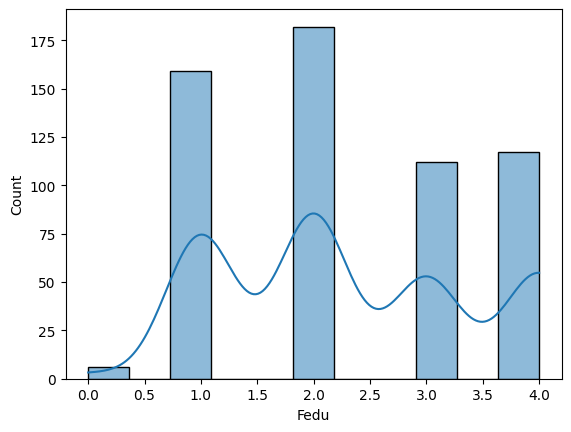

In [20]:
sns.histplot(df['Fedu'],kde=True)

Since this is multimodal feature I will use KNN imputer instead of mean median mode filling .

In [21]:
salary_map = {
    'at_home': 1,
    'other': 2,
    'services': 3,
    'health': 4,
    'teacher': 5
}
df['Mjob'] = df['Mjob'].map(salary_map)
df['Fjob'] = df['Fjob'].map(salary_map)


In [22]:
df['gaurdian_mother']=df['gaurdian_mother'].astype("int")
df['gaurdian_other']=df['gaurdian_other'].astype("int")

In [23]:
df['reason'].unique()

array(['course', 'other', 'home', 'reputation'], dtype=object)

In [24]:
df

,school,sex,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,traveltime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,famrel,freetime,goout,Dalc,health,absences,G1,G2,G3,Feature_1,Feature_2,Feature_3,romantic,gaurdian_mother,gaurdian_other
0,0.651772,1,1,4,0,4,4.0,1,5,course,2.0,0,1,0,0,0,1,1.0,0,4,3.0,4,1,3,4.0,0,11.0,11,18.0,2.0,1.0,0,1,0
1,0.651772,1,1,4,1,1,1.0,1,2,course,NaN,0,0,1,0,0,0,1.0,1,5,3.0,3,1,3,2.0,9,11.0,11,17.0,2.0,1.0,0,0,0
2,0.651772,1,1,2,1,1,1.0,1,2,other,1.0,0,1,0,0,0,1,1.0,1,4,3.0,2,2,3,6.0,12,13.0,12,15.0,NaN,3.0,0,1,0
3,0.651772,1,1,4,1,4,2.0,4,3,home,1.0,0,0,1,0,1,1,1.0,1,3,2.0,2,1,5,0.0,14,14.0,14,15.0,3.0,1.0,1,1,0
4,0.651772,1,1,4,1,3,3.0,2,2,home,1.0,0,0,1,0,0,1,1.0,0,4,3.0,2,1,5,0.0,11,13.0,13,16.0,NaN,2.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,0.348228,1,0,4,1,2,3.0,3,2,course,1.0,1,0,0,0,1,0,1.0,1,5,4.0,2,1,5,4.0,10,11.0,10,19.0,3.0,2.0,0,1,0
645,0.348228,1,1,2,1,3,1.0,5,3,course,1.0,0,0,1,0,0,1,NaN,1,4,NaN,4,1,1,NaN,15,15.0,16,18.0,2.0,1.0,0,1,0
646,0.348228,1,1,4,1,1,1.0,2,2,course,2.0,0,0,0,0,1,1,1.0,0,1,1.0,1,1,5,6.0,11,12.0,9,18.0,NaN,1.0,0,1,0
647,0.348228,0,1,2,1,3,1.0,3,3,course,2.0,0,0,0,0,0,0,1.0,1,2,4.0,5,3,2,6.0,10,10.0,10,NaN,1.0,4.0,0,1,0


In [25]:
grade_cols = ['G1', 'G2', 'G3']
df_temp = df.dropna(subset=grade_cols)
df_temp["grade"]=(df_temp['G1']+df_temp['G2']+df_temp['G3'])/3
mean_grades_by_reason = df_temp.groupby('reason')["grade"].agg(['mean', 'median','std'])
print(mean_grades_by_reason)

                 mean     median       std
reason                                    
course      11.268143  11.000000  2.770705
home        11.908873  12.000000  2.517829
other       10.628019  10.666667  3.098353
reputation  12.641975  13.000000  2.840605


<ipython-input-25-eb03133eae48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["grade"]=(df_temp['G1']+df_temp['G2']+df_temp['G3'])/3


as mean of grade increase that mean te importance of that feature increase so i am going to fill it ordinally as weight of feture increses if it's value  increases

In [26]:
#  using the above encoding the reason in numeric
df['reason']=df['reason'].map({'other':1,"course":2,"home":3,"reputation":4})

In [27]:
df

,school,sex,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,traveltime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,famrel,freetime,goout,Dalc,health,absences,G1,G2,G3,Feature_1,Feature_2,Feature_3,romantic,gaurdian_mother,gaurdian_other
0,0.651772,1,1,4,0,4,4.0,1,5,2,2.0,0,1,0,0,0,1,1.0,0,4,3.0,4,1,3,4.0,0,11.0,11,18.0,2.0,1.0,0,1,0
1,0.651772,1,1,4,1,1,1.0,1,2,2,NaN,0,0,1,0,0,0,1.0,1,5,3.0,3,1,3,2.0,9,11.0,11,17.0,2.0,1.0,0,0,0
2,0.651772,1,1,2,1,1,1.0,1,2,1,1.0,0,1,0,0,0,1,1.0,1,4,3.0,2,2,3,6.0,12,13.0,12,15.0,NaN,3.0,0,1,0
3,0.651772,1,1,4,1,4,2.0,4,3,3,1.0,0,0,1,0,1,1,1.0,1,3,2.0,2,1,5,0.0,14,14.0,14,15.0,3.0,1.0,1,1,0
4,0.651772,1,1,4,1,3,3.0,2,2,3,1.0,0,0,1,0,0,1,1.0,0,4,3.0,2,1,5,0.0,11,13.0,13,16.0,NaN,2.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,0.348228,1,0,4,1,2,3.0,3,2,2,1.0,1,0,0,0,1,0,1.0,1,5,4.0,2,1,5,4.0,10,11.0,10,19.0,3.0,2.0,0,1,0
645,0.348228,1,1,2,1,3,1.0,5,3,2,1.0,0,0,1,0,0,1,NaN,1,4,NaN,4,1,1,NaN,15,15.0,16,18.0,2.0,1.0,0,1,0
646,0.348228,1,1,4,1,1,1.0,2,2,2,2.0,0,0,0,0,1,1,1.0,0,1,1.0,1,1,5,6.0,11,12.0,9,18.0,NaN,1.0,0,1,0
647,0.348228,0,1,2,1,3,1.0,3,3,2,2.0,0,0,0,0,0,0,1.0,1,2,4.0,5,3,2,6.0,10,10.0,10,NaN,1.0,4.0,0,1,0


In [28]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

<Axes: >

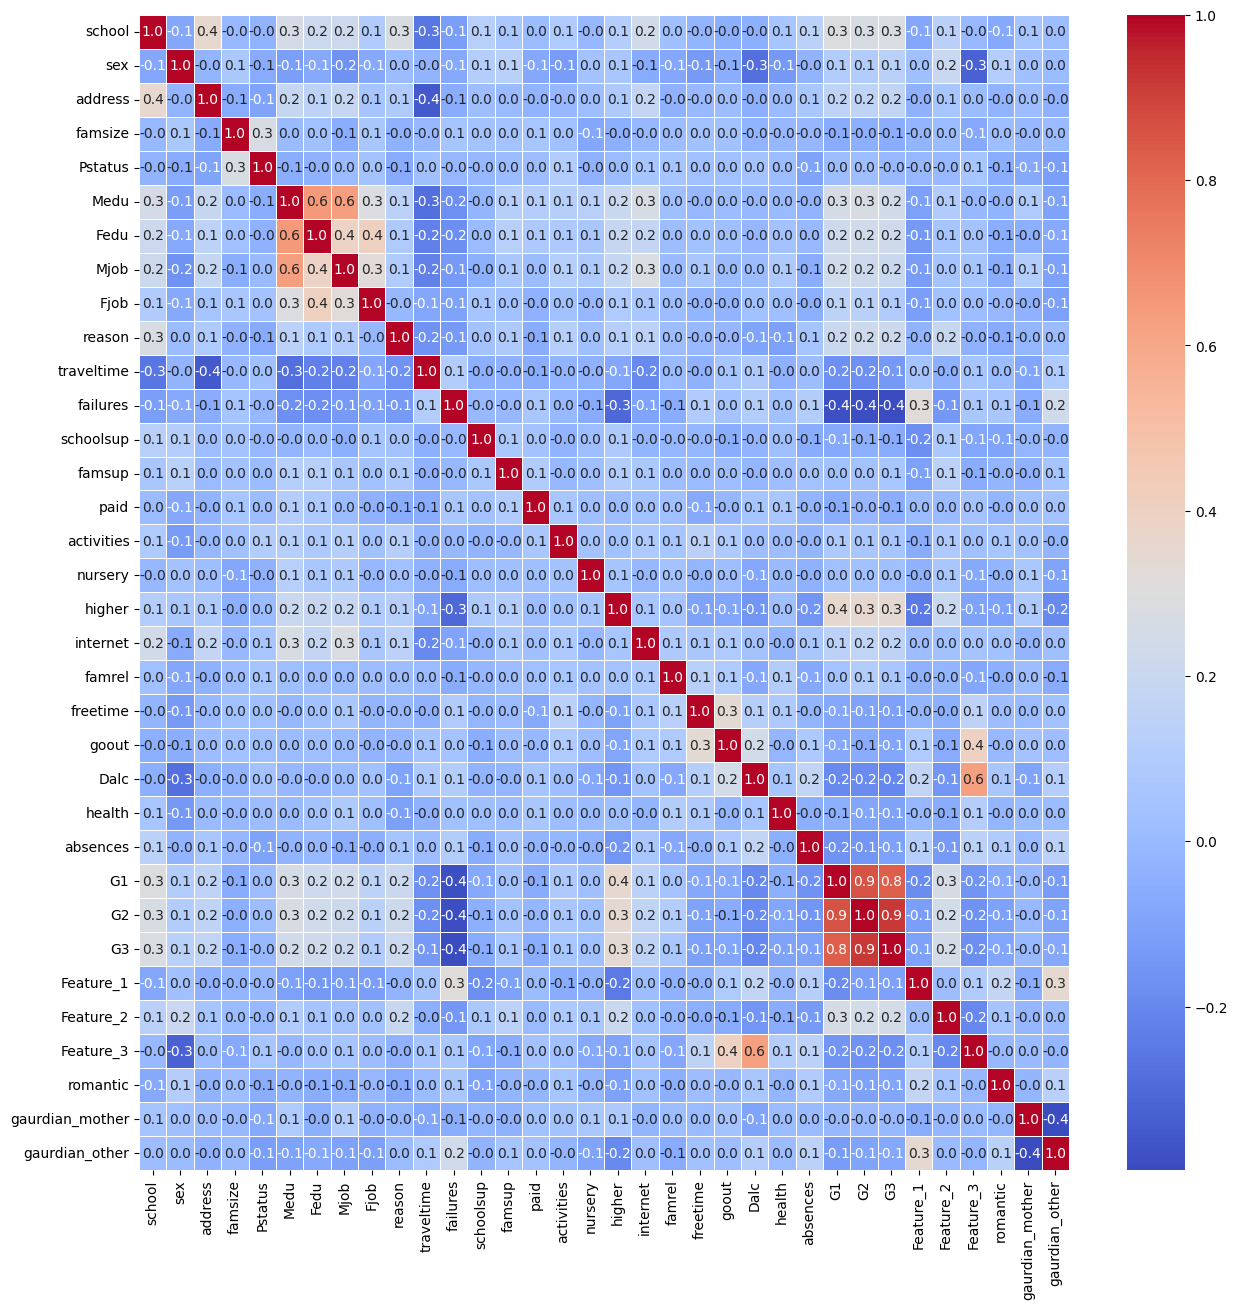

In [29]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm',fmt='.1f',linewidths=0.5)

In [30]:
null_col=df.isnull().sum()
null_col=null_col[null_col>0]
null_col

,0
Fedu,73
traveltime,73
higher,76
freetime,45
absences,69
G2,35
Feature_1,38
Feature_2,46
Feature_3,39


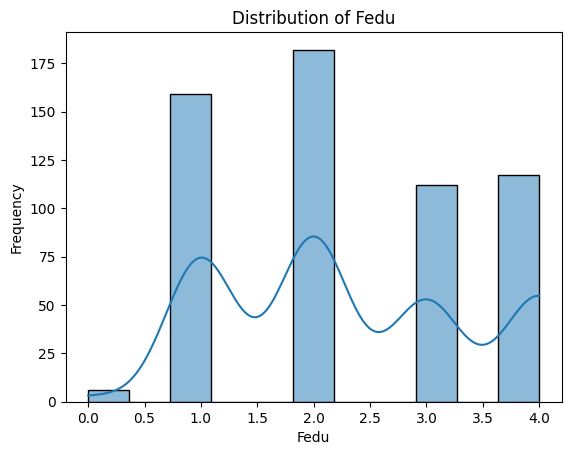

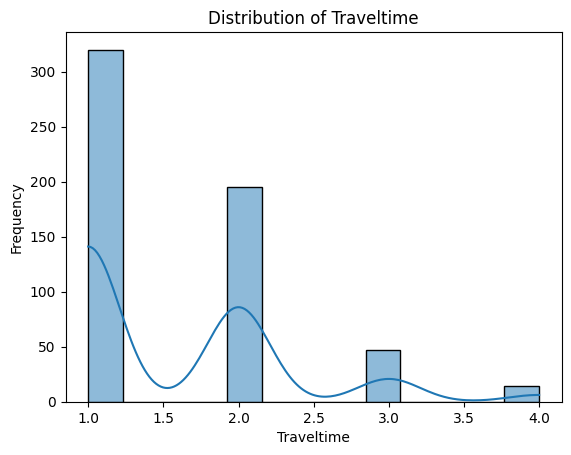

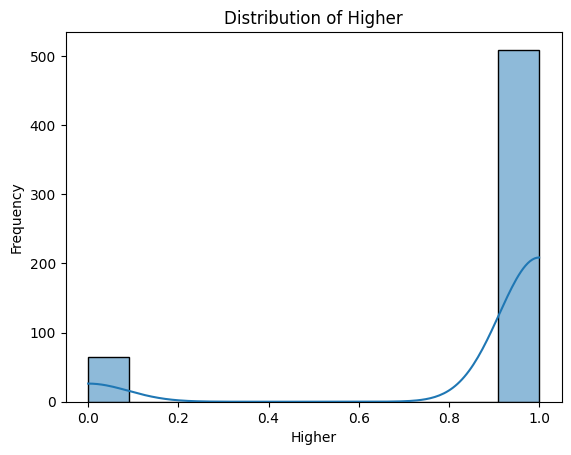

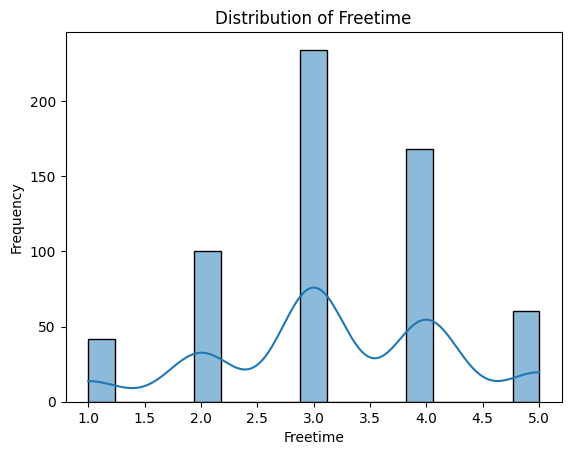

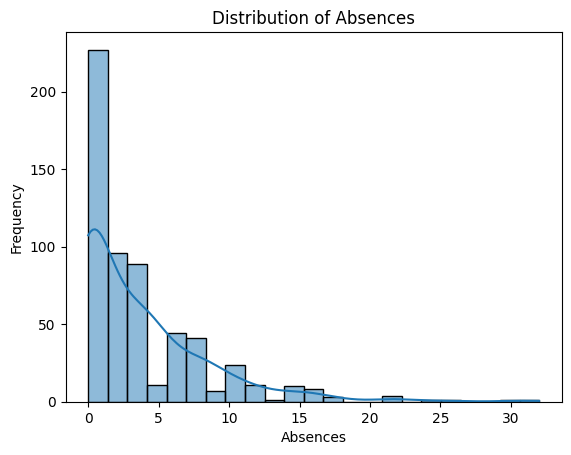

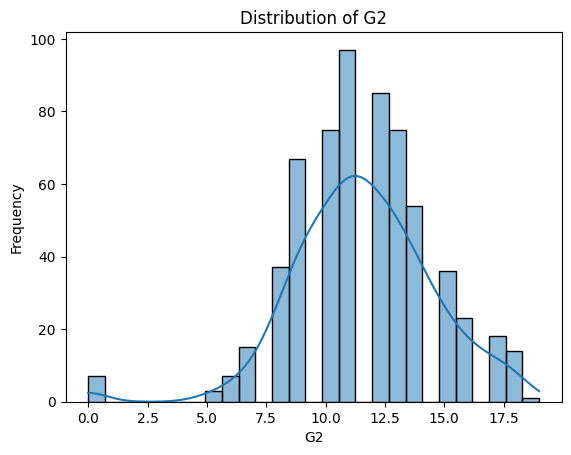

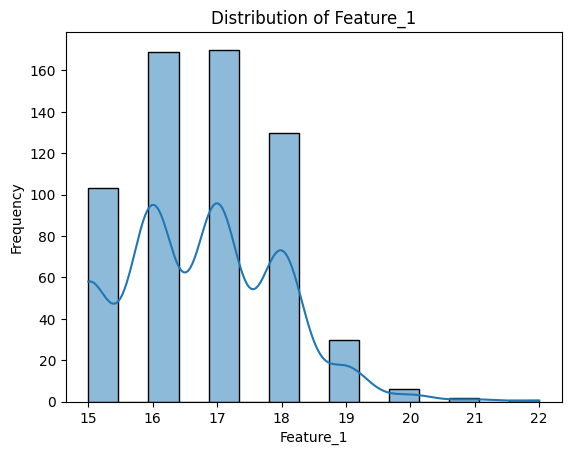

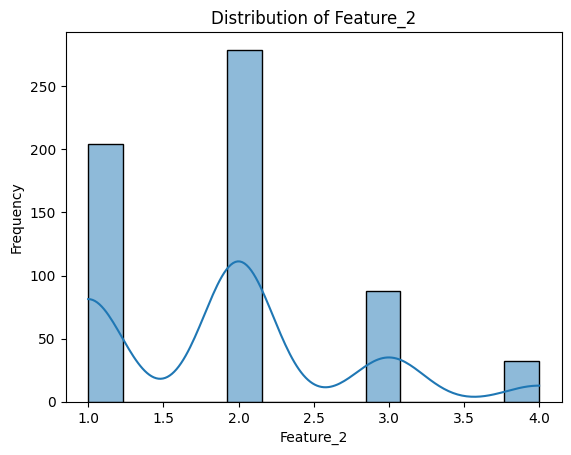

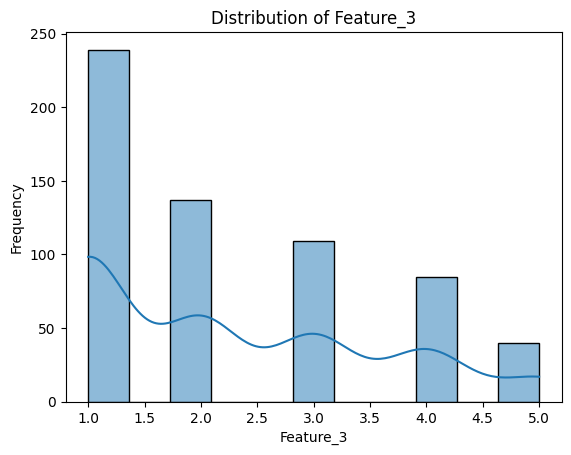

In [31]:
# Plot for 'Fedu'
sns.histplot(df['Fedu'], kde=True)
plt.title('Distribution of Fedu')
plt.xlabel('Fedu')
plt.ylabel('Frequency')
plt.show()

# Plot for 'traveltime'
sns.histplot(df['traveltime'], kde=True)
plt.title('Distribution of Traveltime')
plt.xlabel('Traveltime')
plt.ylabel('Frequency')
plt.show()

# Plot for 'higher'
sns.histplot(df['higher'], kde=True)
plt.title('Distribution of Higher')
plt.xlabel('Higher')
plt.ylabel('Frequency')
plt.show()

# Plot for 'freetime'
sns.histplot(df['freetime'], kde=True)
plt.title('Distribution of Freetime')
plt.xlabel('Freetime')
plt.ylabel('Frequency')
plt.show()

# Plot for 'absences'
sns.histplot(df['absences'], kde=True)
plt.title('Distribution of Absences')
plt.xlabel('Absences')
plt.ylabel('Frequency')
plt.show()

# Plot for 'G2'
sns.histplot(df['G2'], kde=True)
plt.title('Distribution of G2')
plt.xlabel('G2')
plt.ylabel('Frequency')
plt.show()

# Plot for 'Feature_1'
sns.histplot(df['Feature_1'], kde=True)
plt.title('Distribution of Feature_1')
plt.xlabel('Feature_1')
plt.ylabel('Frequency')
plt.show()

# Plot for 'Feature_2'
sns.histplot(df['Feature_2'], kde=True)
plt.title('Distribution of Feature_2')
plt.xlabel('Feature_2')
plt.ylabel('Frequency')
plt.show()

# Plot for 'Feature_3'
sns.histplot(df['Feature_3'], kde=True)
plt.title('Distribution of Feature_3')
plt.xlabel('Feature_3')
plt.ylabel('Frequency')
plt.show()


In [32]:
df

,school,sex,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,traveltime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,famrel,freetime,goout,Dalc,health,absences,G1,G2,G3,Feature_1,Feature_2,Feature_3,romantic,gaurdian_mother,gaurdian_other
0,0.651772,1,1,4,0,4,4.0,1,5,2,2.0,0,1,0,0,0,1,1.0,0,4,3.0,4,1,3,4.0,0,11.0,11,18.0,2.0,1.0,0,1,0
1,0.651772,1,1,4,1,1,1.0,1,2,2,NaN,0,0,1,0,0,0,1.0,1,5,3.0,3,1,3,2.0,9,11.0,11,17.0,2.0,1.0,0,0,0
2,0.651772,1,1,2,1,1,1.0,1,2,1,1.0,0,1,0,0,0,1,1.0,1,4,3.0,2,2,3,6.0,12,13.0,12,15.0,NaN,3.0,0,1,0
3,0.651772,1,1,4,1,4,2.0,4,3,3,1.0,0,0,1,0,1,1,1.0,1,3,2.0,2,1,5,0.0,14,14.0,14,15.0,3.0,1.0,1,1,0
4,0.651772,1,1,4,1,3,3.0,2,2,3,1.0,0,0,1,0,0,1,1.0,0,4,3.0,2,1,5,0.0,11,13.0,13,16.0,NaN,2.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,0.348228,1,0,4,1,2,3.0,3,2,2,1.0,1,0,0,0,1,0,1.0,1,5,4.0,2,1,5,4.0,10,11.0,10,19.0,3.0,2.0,0,1,0
645,0.348228,1,1,2,1,3,1.0,5,3,2,1.0,0,0,1,0,0,1,NaN,1,4,NaN,4,1,1,NaN,15,15.0,16,18.0,2.0,1.0,0,1,0
646,0.348228,1,1,4,1,1,1.0,2,2,2,2.0,0,0,0,0,1,1,1.0,0,1,1.0,1,1,5,6.0,11,12.0,9,18.0,NaN,1.0,0,1,0
647,0.348228,0,1,2,1,3,1.0,3,3,2,2.0,0,0,0,0,0,0,1.0,1,2,4.0,5,3,2,6.0,10,10.0,10,NaN,1.0,4.0,0,1,0


In [33]:
# # Replacing  0s (if any) to avoid log(0)
# df['absences'] = df['absences'].replace(0, 0.1)

# # Apply log transformation to normalise the distribution
# df['absences_log'] = np.log(df['absences'])

# df['absences'] = df['absences_log'].fillna(df['absences_log'].median())
# df.drop('absences_log',axis=1,inplace=True)

# sns.histplot(df['absences'], kde=True)
# plt.title('Absences Distribution After Imputation')
# plt.show()

As there is only one missing column that is normal so i can fill it with median or Knn imputer but it will depend on the accuracy of my model later


In [34]:
# here failure is only one that is inversly proportinoal to Higher
features = ['G1', 'G2', 'G3', 'failures', 'higher']
df_temp = df[features].copy()
imputer = KNNImputer(n_neighbors=3)
df_temp_imputed = imputer.fit_transform(df_temp)
df_temp_imputed = pd.DataFrame(df_temp_imputed, columns=features, index=df_temp.index)
df['higher'] = df_temp_imputed['higher']
print(df['higher'].isnull().sum())

0


In [35]:
# for travel time
features = ['G1', 'G2', 'internet','Medu','address','school','traveltime']
df_temp = df[features].copy()
imputer = KNNImputer(n_neighbors=3)
df_temp_imputed = imputer.fit_transform(df_temp)
df_temp_imputed = pd.DataFrame(df_temp_imputed, columns=features, index=df_temp.index)
df['traveltime'] = df_temp_imputed['traveltime']
print(df['traveltime'].isnull().sum())


0


In [36]:
#  for Freetime
features = ['freetime','goout']
df_temp = df[features].copy()
imputer = KNNImputer(n_neighbors=3)
df_temp_imputed = imputer.fit_transform(df_temp)
df_temp_imputed = pd.DataFrame(df_temp_imputed, columns=features, index=df_temp.index)
df['freetime'] = df_temp_imputed['freetime']
print(df['freetime'].isnull().sum())

0


In [37]:
# For Absences
features = ['absences','higher','Dalc','G1']
df_temp = df[features].copy()
imputer = KNNImputer(n_neighbors=3)
df_temp_imputed = imputer.fit_transform(df_temp)
df_temp_imputed = pd.DataFrame(df_temp_imputed, columns=features, index=df_temp.index)
df['absences'] = df_temp_imputed['absences']
print(df['absences'].isnull().sum())

0


In [38]:
# For G2
features = ['G2','school','Medu','Fedu','Mjob','reason','higher','G1','G3']
df_temp = df[features].copy()
imputer = KNNImputer(n_neighbors=3)
df_temp_imputed = imputer.fit_transform(df_temp)
df_temp_imputed = pd.DataFrame(df_temp_imputed, columns=features, index=df_temp.index)
df['G2'] = df_temp_imputed['G2']
print(df['G2'].isnull().sum())

0


In [39]:
# For Feature_1
features = ['Feature_1','failures','gaurdian_other','school','schoolsup','higher','Dalc','G1','romantic']
df_temp = df[features].copy()
imputer = KNNImputer(n_neighbors=3)
df_temp_imputed = imputer.fit_transform(df_temp)
df_temp_imputed = pd.DataFrame(df_temp_imputed, columns=features, index=df_temp.index)
df['Feature_1'] = df_temp_imputed['Feature_1']
print(df['Feature_1'].isnull().sum())

0


In [40]:
# For Feature_2
features = ['Feature_2','sex','reason','higher','G1','G2','G3','Feature_3','Dalc']
df_temp = df[features].copy()
imputer = KNNImputer(n_neighbors=3)
df_temp_imputed = imputer.fit_transform(df_temp)
df_temp_imputed = pd.DataFrame(df_temp_imputed, columns=features, index=df_temp.index)
df['Feature_2'] = df_temp_imputed['Feature_2']
print(df['Feature_2'].isnull().sum())

0


In [41]:
# For Feature_3
features = ['Feature_3','sex','goout','Dalc','G1','G2','G3','Feature_2']
df_temp = df[features].copy()
imputer = KNNImputer(n_neighbors=3)
df_temp_imputed = imputer.fit_transform(df_temp)
df_temp_imputed = pd.DataFrame(df_temp_imputed, columns=features, index=df_temp.index)
df['Feature_3'] = df_temp_imputed['Feature_3']
print(df['Feature_3'].isnull().sum())

0


In [42]:
# dropping those two rows in which Fedu is null
df=df.dropna(subset=['Fedu'])

In [43]:
df

,school,sex,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,traveltime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,famrel,freetime,goout,Dalc,health,absences,G1,G2,G3,Feature_1,Feature_2,Feature_3,romantic,gaurdian_mother,gaurdian_other
0,0.651772,1,1,4,0,4,4.0,1,5,2,2.000000,0,1,0,0,0,1,1.0,0,4,3.0,4,1,3,4.0,0,11.0,11,18.000000,2.000000,1.0,0,1,0
1,0.651772,1,1,4,1,1,1.0,1,2,2,1.333333,0,0,1,0,0,0,1.0,1,5,3.0,3,1,3,2.0,9,11.0,11,17.000000,2.000000,1.0,0,0,0
2,0.651772,1,1,2,1,1,1.0,1,2,1,1.000000,0,1,0,0,0,1,1.0,1,4,3.0,2,2,3,6.0,12,13.0,12,15.000000,1.666667,3.0,0,1,0
3,0.651772,1,1,4,1,4,2.0,4,3,3,1.000000,0,0,1,0,1,1,1.0,1,3,2.0,2,1,5,0.0,14,14.0,14,15.000000,3.000000,1.0,1,1,0
4,0.651772,1,1,4,1,3,3.0,2,2,3,1.000000,0,0,1,0,0,1,1.0,0,4,3.0,2,1,5,0.0,11,13.0,13,16.000000,2.000000,2.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,0.348228,1,0,4,1,2,3.0,3,2,2,1.000000,1,0,0,0,1,0,1.0,1,5,4.0,2,1,5,4.0,10,11.0,10,19.000000,3.000000,2.0,0,1,0
645,0.348228,1,1,2,1,3,1.0,5,3,2,1.000000,0,0,1,0,0,1,1.0,1,4,4.0,4,1,1,2.0,15,15.0,16,18.000000,2.000000,1.0,0,1,0
646,0.348228,1,1,4,1,1,1.0,2,2,2,2.000000,0,0,0,0,1,1,1.0,0,1,1.0,1,1,5,6.0,11,12.0,9,18.000000,3.000000,1.0,0,1,0
647,0.348228,0,1,2,1,3,1.0,3,3,2,2.000000,0,0,0,0,0,0,1.0,1,2,4.0,5,3,2,6.0,10,10.0,10,16.333333,1.000000,4.0,0,1,0


In [44]:
print(df['Feature_1'].agg(['mean','median','std','max','min']))
print(df['Feature_2'].agg(['mean','median','std','max','min']))
print(df['Feature_3'].agg(['mean','median','std','max','min']))

mean      16.719329
median    17.000000
std        1.202463
max       22.000000
min       15.000000
Name: Feature_1, dtype: float64
mean      1.928819
median    2.000000
std       0.816820
max       4.000000
min       1.000000
Name: Feature_2, dtype: float64
mean      2.290509
median    2.000000
std       1.268457
max       5.000000
min       1.000000
Name: Feature_3, dtype: float64


<Axes: >

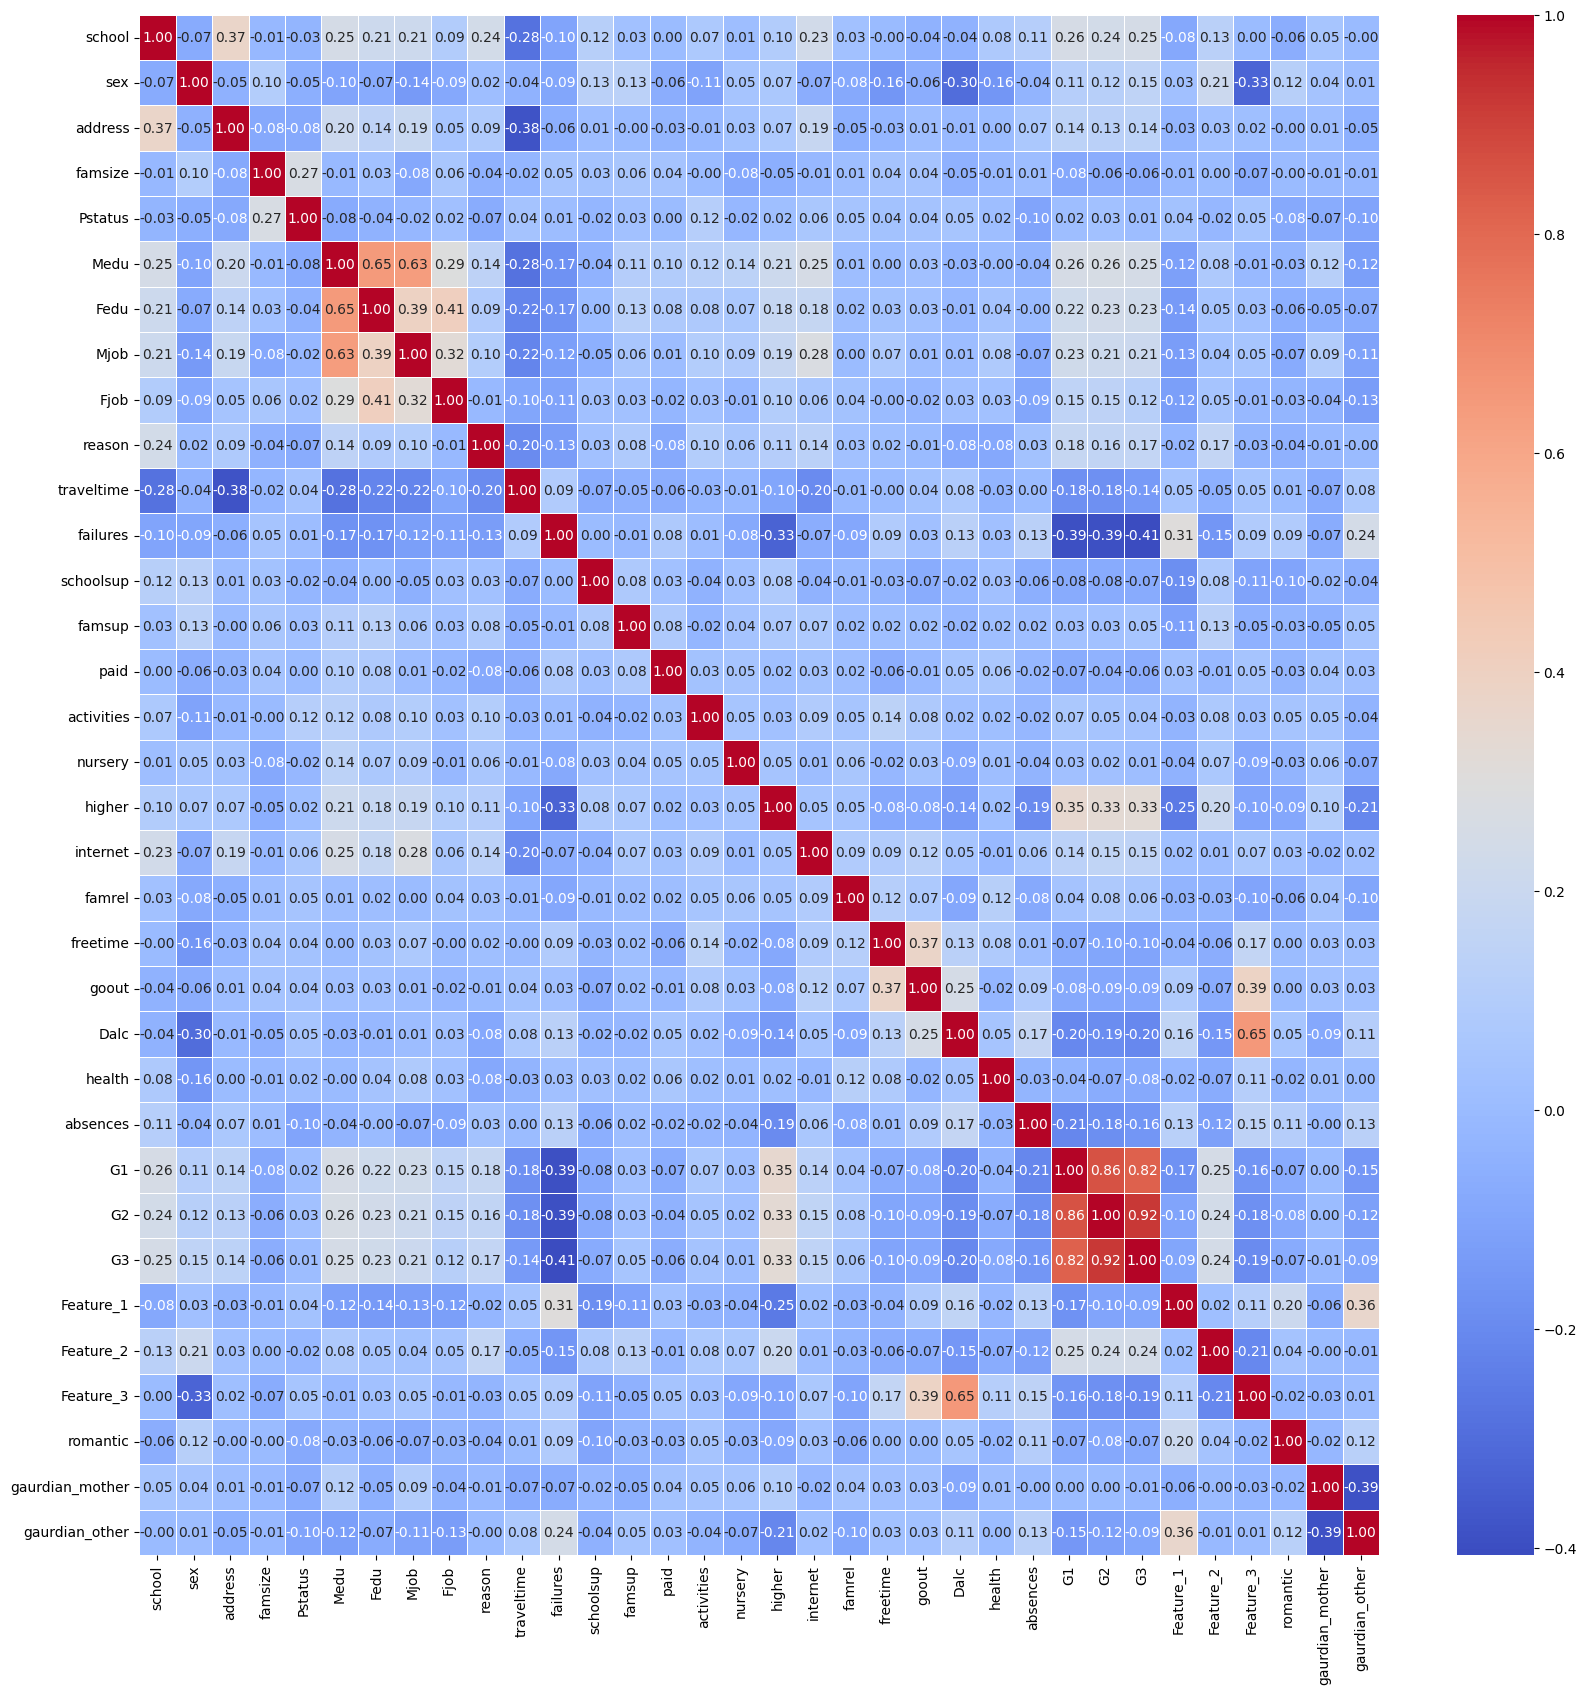

In [45]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm',fmt='.2f',linewidths=0.5)

In [46]:
df[['Feature_1']].describe()


,Feature_1
count,576.000000
mean,16.719329
std,1.202463
min,15.000000
25%,16.000000
50%,17.000000
75%,17.750000
max,22.000000


Feature_1 is probably the age of the students. This is just a guess based on the data, not a confirmed fact. Here's why I think so:

    About 75% of the students are 18 or younger

    The average age is 16.7 and the middle value (median) is 17

    This fits with the usual age of high school students

When I checked the histogram and KDE plot, most of the values are between 15 and 22, which is the common age range for students.

To check this further, I made boxplots with absences, freetime, health, and travel time. If Feature_1 is really age, we might see patterns that match what we expect for students.

So, looking at the graphs and basic stats, it seems very likely that Feature_1 shows age, but it's still a pre-assumption, not confirmed

<ipython-input-47-dacb92b93c83>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_bin'] = pd.cut(df['Feature_1'], bins=[15, 16, 17, 18, 19, 20, 21, 22], right=True, include_lowest=True)


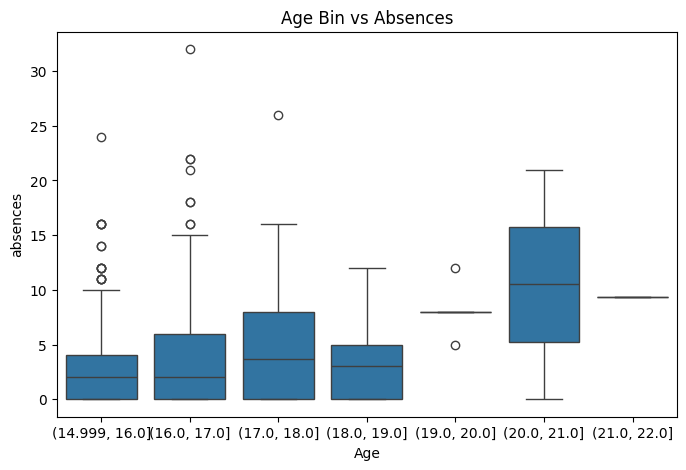

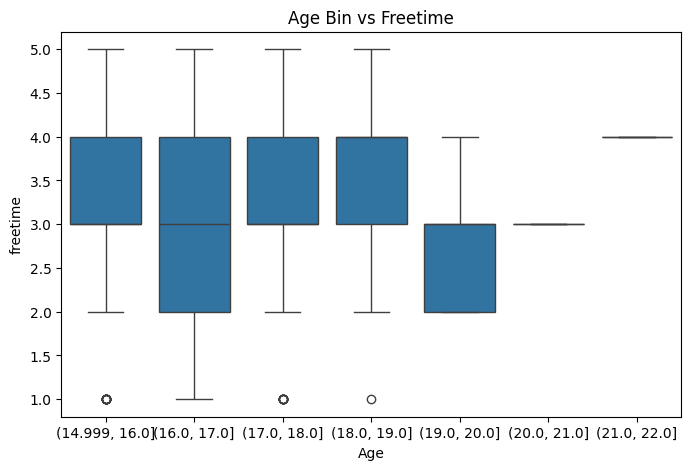

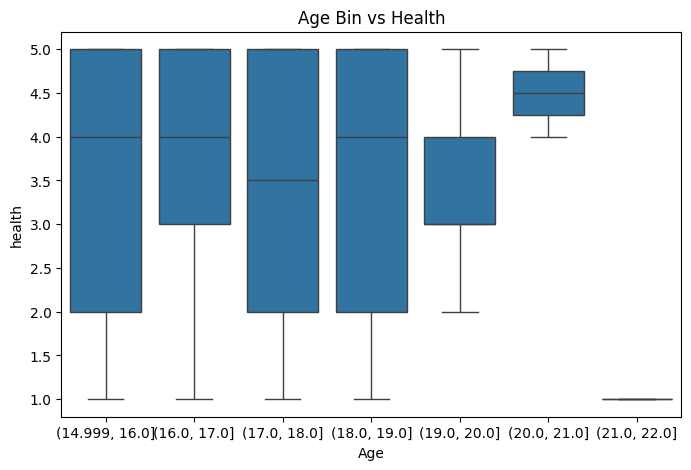

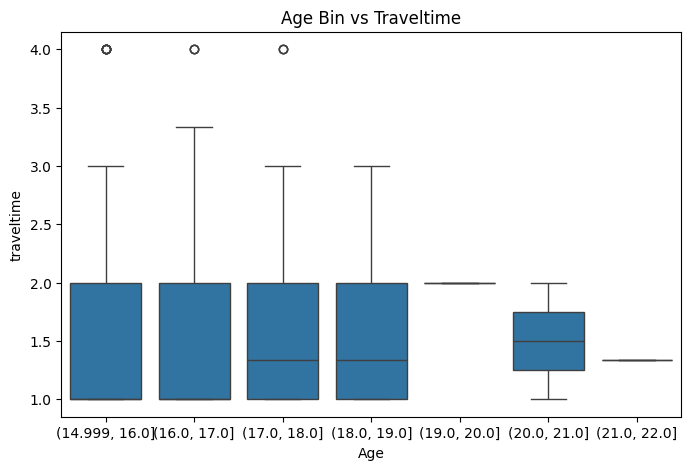

In [47]:
df['age_bin'] = pd.cut(df['Feature_1'], bins=[15, 16, 17, 18, 19, 20, 21, 22], right=True, include_lowest=True)

plt.figure(figsize=(8, 5))
sns.boxplot(x='age_bin', y='absences', data=df)
plt.title('Age Bin vs Absences')
plt.xlabel('Age')
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x='age_bin', y='freetime', data=df)
plt.title('Age Bin vs Freetime')
plt.xlabel('Age')
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x='age_bin', y='health', data=df)
plt.title('Age Bin vs Health')
plt.xlabel('Age')
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x='age_bin', y='traveltime', data=df)
plt.title('Age Bin vs Traveltime')
plt.xlabel('Age')
plt.show()


From these plots, we can be confident that Feature_1 represents the students’ age.
Most of the data is between ages 15 to 22, and especially between 15 to 19, which matches the age of school-going students. After 19, there are very few students in the data. This shows that many students may not continue to college, maybe because of family situations or needing to earn money.

When we look at the absences, students aged 15 to 19 have fewer absences, which is normal for school students. But after age 19, absences become higher, especially at age 20 and 21. This could be because older students may be working or focusing on skills, jobs, or family responsibilities, so they miss more classes.

Other graphs like freetime, health, and traveltime don’t show any strong pattern, maybe because the data is almost the same for all ages, or there are too few students at higher ages to see a clear trend.

So, based on all this, we can say that Feature_1 is the age of the students.

# Feature_2 prediction

In [48]:
df['Feature_2'].describe()

,Feature_2
count,576.000000
mean,1.928819
std,0.816820
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,4.000000


<ipython-input-49-f2b2097a9677>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_2_corr.values, y=feature_2_corr.index, palette='viridis')


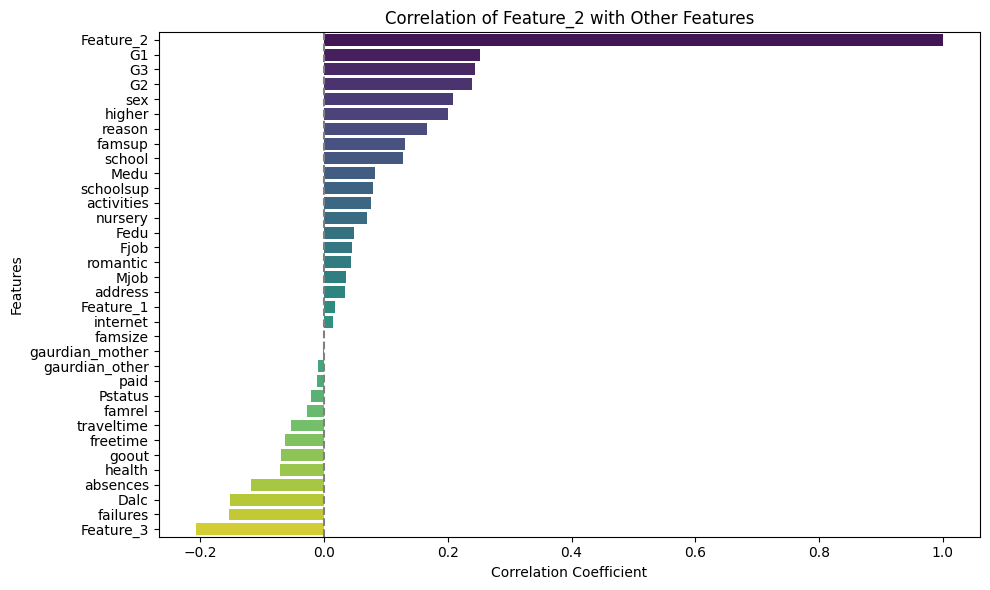

In [49]:
correlation = df.corr(numeric_only=True)
feature_2_corr = correlation['Feature_2'].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_2_corr.values, y=feature_2_corr.index, palette='viridis')
plt.title('Correlation of Feature_2 with Other Features')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

from the above we will explore the features with most corelation with feature_2


In [50]:
df['avg_grade']=(df['G1']+df['G2']+df['G3'])/3

<ipython-input-50-ba8b3328cee5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_grade']=(df['G1']+df['G2']+df['G3'])/3


<Axes: xlabel='Feature_2', ylabel='count'>

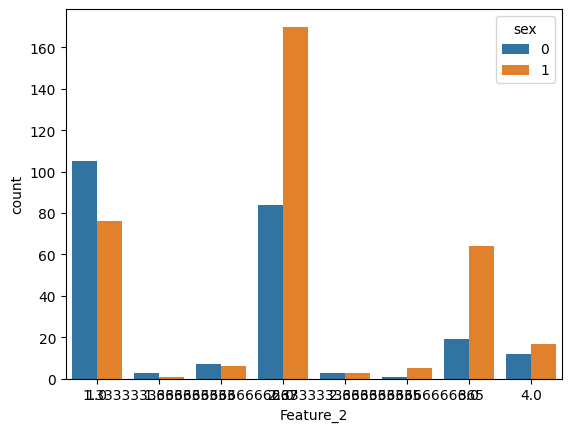

In [51]:
sns.countplot(data=df,x='Feature_2',hue='sex')

At every section density of Female is more as compared to man


In [52]:
df['higher'].unique()

array([1.        , 0.66666667, 0.        , 0.33333333])

<ipython-input-53-0ca8e5ada329>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby(['Feature_2_bin', 'higher']).size().reset_index(name='count')
<ipython-input-53-0ca8e5ada329>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_in_bin = df_temp.groupby('Feature_2_bin').size().reset_index(name='total')


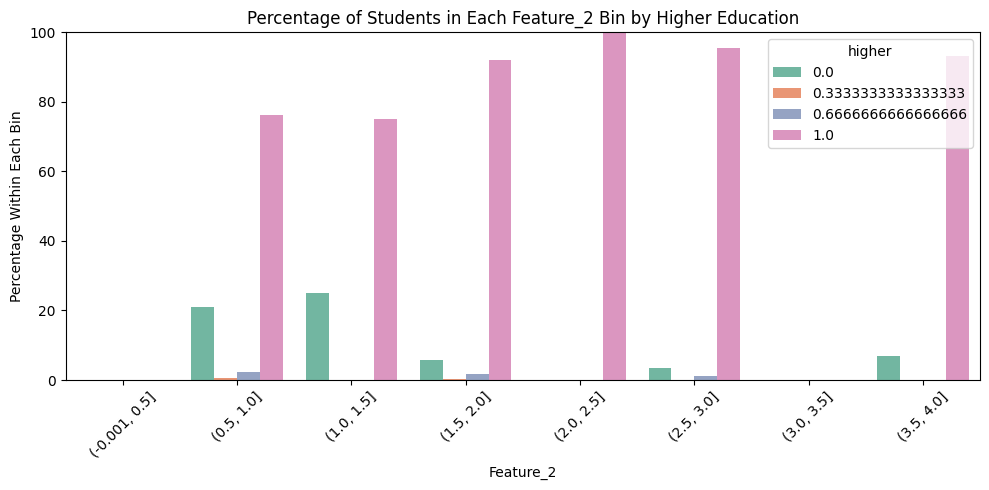

In [53]:

df_temp = df.copy()
bins = np.arange(0, 4.5, 0.5)
df_temp['Feature_2_bin'] = pd.cut(df_temp['Feature_2'], bins=bins, include_lowest=True)

# Grouping  by bin and higher, and count
grouped = df_temp.groupby(['Feature_2_bin', 'higher']).size().reset_index(name='count')

# Calculating total students in each bin
total_in_bin = df_temp.groupby('Feature_2_bin').size().reset_index(name='total')

# Merging total count into grouped DataFrame
grouped = grouped.merge(total_in_bin, on='Feature_2_bin')

# Calculating % within each bin
grouped['percentage'] = (grouped['count'] / grouped['total']) * 100

plt.figure(figsize=(10, 5))
sns.barplot(data=grouped, x='Feature_2_bin', y='percentage', hue='higher', palette='Set2')

plt.title('Percentage of Students in Each Feature_2 Bin by Higher Education')
plt.xlabel('Feature_2')
plt.ylabel('Percentage Within Each Bin')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


As Feature_2 increase student not going to higher decreases and students going to hiigher increases

<ipython-input-54-29953d728403>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp.groupby(['Feature_2_bin', 'Dalc']).size()
<ipython-input-54-29953d728403>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=0).apply(lambda x: 100 * x / x.sum())


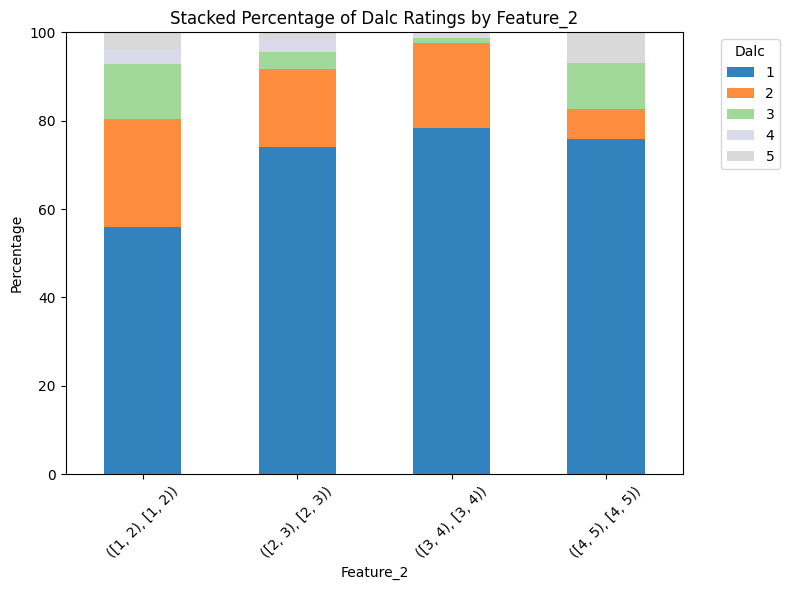

In [54]:
df_temp = df.copy()
bins = np.arange(1, 5, 1)
bins = np.append(bins, 5)
# Create categorical bins for Feature_2
df_temp['Feature_2_bin'] = pd.cut(df_temp['Feature_2'], bins=bins, right=False, include_lowest=True)

# Calculating percentage of Dalc within each Feature_2_bin
percent_df = (
    df_temp.groupby(['Feature_2_bin', 'Dalc']).size()
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())
    .unstack(fill_value=0)
)

percent_df.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='tab20c')

plt.title('Stacked Percentage of Dalc Ratings by Feature_2')
plt.ylabel('Percentage')
plt.xlabel('Feature_2')
plt.legend(title='Dalc', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

<ipython-input-55-a09769dcc98d>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp.groupby(['Feature_2_bin', 'failures']).size()
<ipython-input-55-a09769dcc98d>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=0).apply(lambda x: 100 * x / x.sum())
<ipython-input-55-a09769dcc98d>:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Failures', bbox_to_anchor=(1.05, 1), loc='upper left')


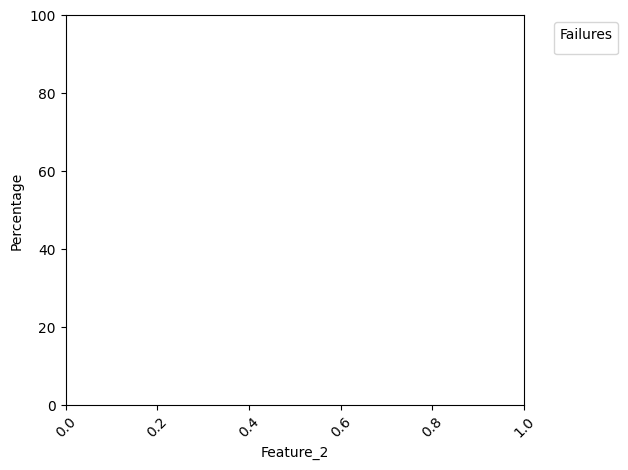

In [55]:
df_temp = df.copy()
bins = np.arange(1, 4, 1)
bins = np.append(bins, 4.5)

df_temp['Feature_2_bin'] = pd.cut(df_temp['Feature_2'], bins=bins, right=False, include_lowest=True)

# Calculating percentage distribution of failures within each Feature_2_bin
percent_df = (
    df_temp.groupby(['Feature_2_bin', 'failures']).size()
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())
    .unstack(fill_value=0)
)

plt.ylabel('Percentage')
plt.xlabel('Feature_2')
plt.legend(title='Failures', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


This graph shows how Feature_2 and failures are connected. When the value of Feature_2 goes up, the number of students who fail goes down. So, if Feature_2 is bigger, students are less likely to fail.

In [56]:
df['avg_grade'].describe()

,avg_grade
count,576.000000
mean,11.623071
std,2.822535
min,1.666667
25%,9.972222
50%,11.666667
75%,13.333333
max,18.666667


<ipython-input-57-0ebd3518d68f>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby(['avg_grade_bin', 'Feature_2_bin']).size()
<ipython-input-57-0ebd3518d68f>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percent_df = grouped.groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack(fill_value=0)


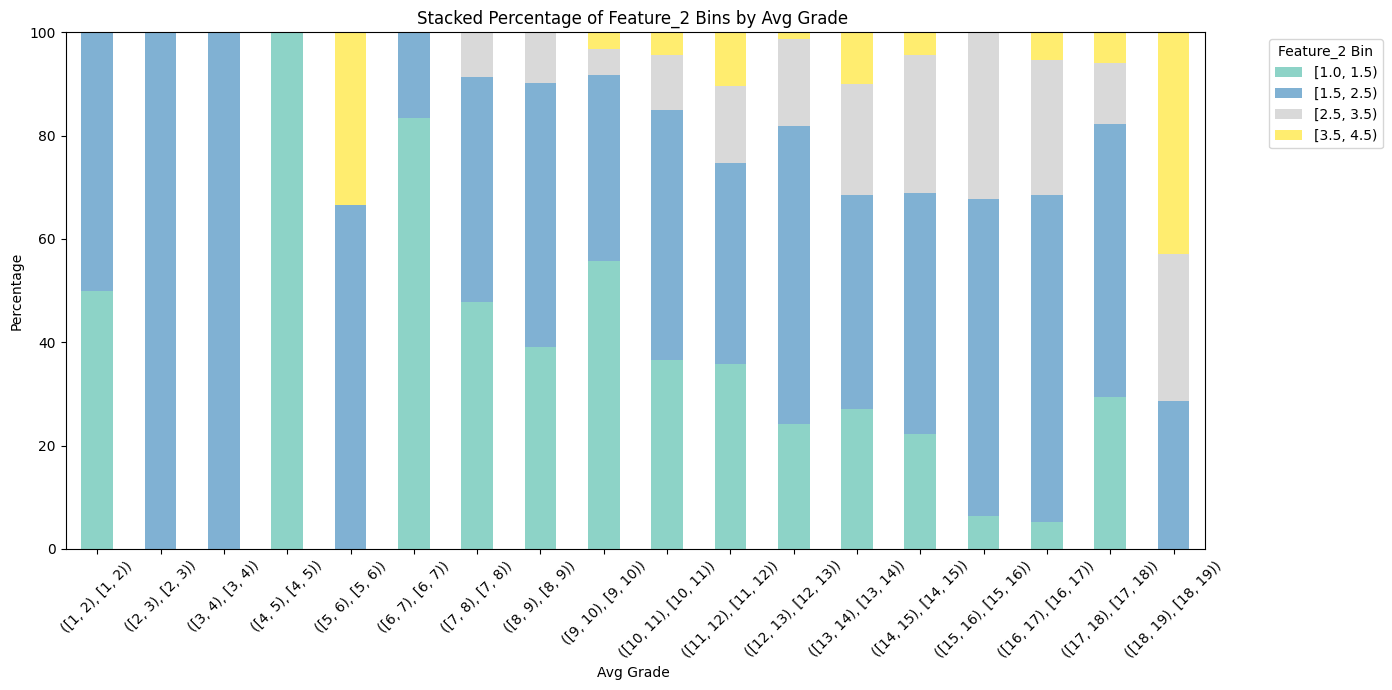

In [57]:

df_temp = df.copy()

feature2_bins = [1, 1.5, 2.5, 3.5, 4.5]
df_temp['Feature_2_bin'] = pd.cut(df_temp['Feature_2'], bins=feature2_bins, right=False, include_lowest=True)

# Bin avg_grade from 1 to 20 with interval 1
avg_grade_bins = np.arange(1, 20, 1)
df_temp['avg_grade_bin'] = pd.cut(df_temp['avg_grade'], bins=avg_grade_bins, right=False, include_lowest=True)

# Grouping by avg_grade_bin and Feature_2_bin, then calculating percentage
grouped = df_temp.groupby(['avg_grade_bin', 'Feature_2_bin']).size()
percent_df = grouped.groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack(fill_value=0)

percent_df.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='Set3')

plt.title('Stacked Percentage of Feature_2 Bins by Avg Grade ')
plt.xlabel('Avg Grade ')
plt.ylabel('Percentage')
plt.legend(title='Feature_2 Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


We can now confidently say that Feature_2 is academic. It appears to have an impact on grades, failures, and other school performance indicators. So it's probably something such as IQ or study time.

However, let's look in detail at the spread of Feature_2.

Most students have Feature_2 values of 1 or 2.

Fewer than 3 students have values of 3 or 4.

This implies that the distribution is not normal or symmetric.

A normal distribution would have more students in the middle (2 and 3) and fewer in the extremes (1 and 4), the way we would like for IQ scores.

So if Feature_2 was IQ, then we would have the highest number of students in the middle. But that is not true here.

This is why IQ may be ruled out as Feature_2.

Instead, it would make more sense if Feature_2 is study hours or effort level:

Most students acquire less or an average, which is indicated by values 1 and 2.

Not many students work hard, something that would be indicated by 3 or 4.

This is what we can conclude from the data. Therefore, it is most likely that Feature_2 is study hours or the level of effort a student puts into studying.

Also, while we were studying the graphs:

Higher Feature_2 scores were associated with fewer failures and better grades.

That also substantiates the notion that it's a matter of how much a student studies. Briefly put, Feature_2 is probably an indicator of study hours — and the more hours students study, the better students they are, since the data tells us

In [58]:
df.drop(['G1','G2','G3'],axis=1,inplace=True)

<ipython-input-58-e46365a8a541>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['G1','G2','G3'],axis=1,inplace=True)


# Feature_3 Prediction

In [59]:
df['Feature_3'].describe()

,Feature_3
count,576.000000
mean,2.290509
std,1.268457
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,5.000000


<Axes: xlabel='Feature_3', ylabel='Count'>

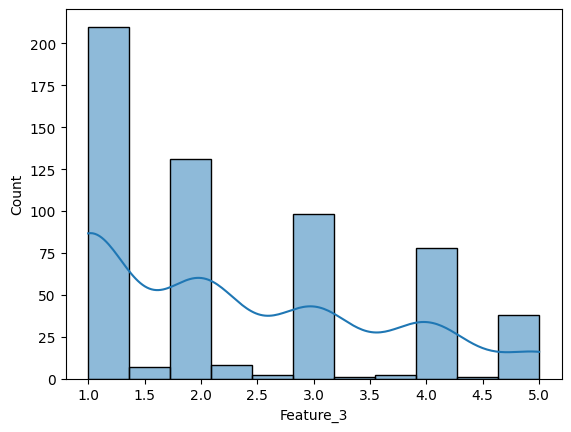

In [60]:
sns.histplot(df['Feature_3'],kde=True)

<ipython-input-61-787a7125ce4c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_3_corr.values, y=feature_3_corr.index, palette='viridis')


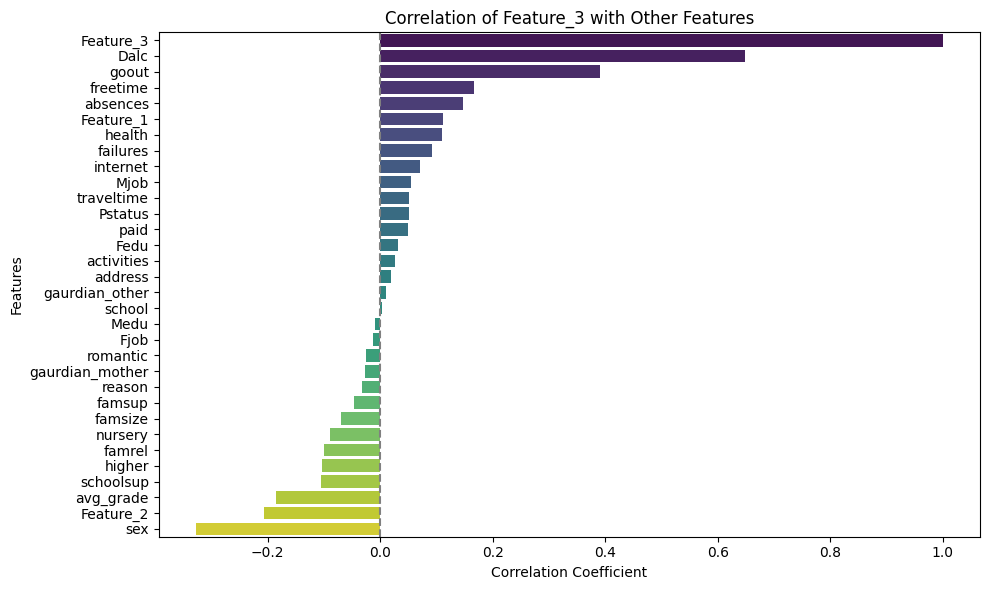

In [61]:
correlation = df.corr(numeric_only=True)
feature_3_corr = correlation['Feature_3'].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_3_corr.values, y=feature_3_corr.index, palette='viridis')
plt.title('Correlation of Feature_3 with Other Features')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

Featuree_3 depend on Features <br>
1:Dalc <br>
2:goout <br>
3:freetimr <br>
4:absences<br>
5:F2<br>
6:avg_grade<br>
<b>We will now explore each and will try to find it's real assences

<ipython-input-62-7262e2cd30fb>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp.groupby(['Feature_3_bin', 'Dalc']).size()
<ipython-input-62-7262e2cd30fb>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=0).apply(lambda x: 100 * x / x.sum())


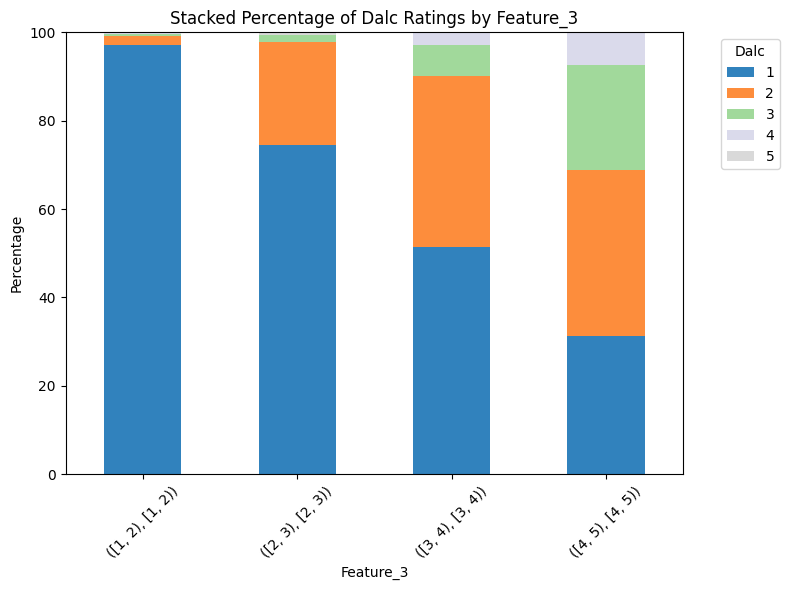

In [62]:
df_temp = df.copy()
bins = np.arange(1, 5, 1)

bins = np.append(bins, 5)

# Create categorical bins for Feature_2
df_temp['Feature_3_bin'] = pd.cut(df_temp['Feature_3'], bins=bins, right=False, include_lowest=True)

# Calculating percentage of Dalc within each Feature_2_bin
percent_df = (
    df_temp.groupby(['Feature_3_bin', 'Dalc']).size()
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())
    .unstack(fill_value=0)
)

percent_df.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='tab20c')

plt.title('Stacked Percentage of Dalc Ratings by Feature_3')
plt.ylabel('Percentage')
plt.xlabel('Feature_3')
plt.legend(title='Dalc', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

<ipython-input-63-cc1468dc79aa>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp.groupby(['Feature_3_bin', 'goout']).size()
<ipython-input-63-cc1468dc79aa>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=0).apply(lambda x: 100 * x / x.sum())


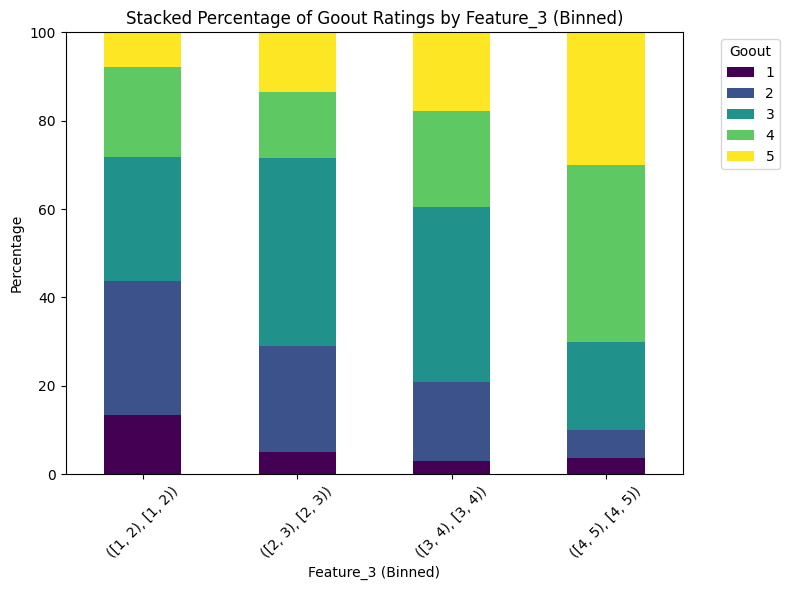

In [63]:
df_temp = df.copy()
bins = np.arange(1, 5, 1)
bins = np.append(bins, 5)

df_temp['Feature_3_bin'] = pd.cut(df_temp['Feature_3'], bins=bins, right=False, include_lowest=True)

# Calculating percentage of goout within each Feature_3_bin
percent_df = (
    df_temp.groupby(['Feature_3_bin', 'goout']).size()
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())
    .unstack(fill_value=0)
)
percent_df.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='viridis')

plt.title('Stacked Percentage of Goout Ratings by Feature_3 (Binned)')
plt.ylabel('Percentage')
plt.xlabel('Feature_3 (Binned)')
plt.legend(title='Goout', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


<ipython-input-64-10c4b8e493d0>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp.groupby(['Feature_3_bin', 'freetime']).size()
<ipython-input-64-10c4b8e493d0>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=0).apply(lambda x: 100 * x / x.sum())


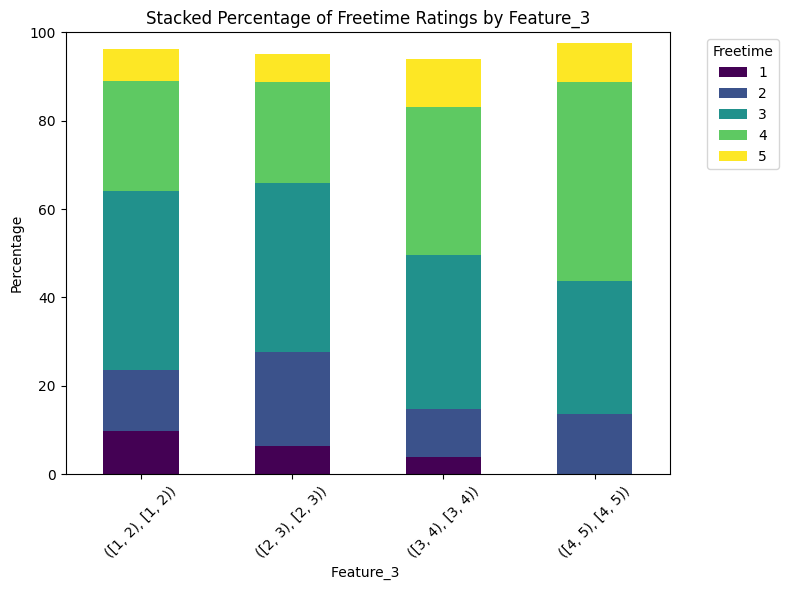

In [64]:
df_temp = df.copy()
bins = np.arange(1, 5, 1)
bins = np.append(bins, 5)

df_temp['Feature_3_bin'] = pd.cut(df_temp['Feature_3'], bins=bins, right=False, include_lowest=True)

# Calculating percentage of freetime within each Feature_3_bin
percent_df = (
    df_temp.groupby(['Feature_3_bin', 'freetime']).size()
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())
    .unstack(fill_value=0)
)

# Ensuring all freetime levels (1–5) are included
percent_df = percent_df.reindex(columns=[1, 2, 3, 4, 5], fill_value=0)

percent_df.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='viridis')

plt.title('Stacked Percentage of Freetime Ratings by Feature_3')
plt.ylabel('Percentage')
plt.xlabel('Feature_3 ')
plt.legend(title='Freetime', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


Most of data is concentrated <br>
unable to find reltion via stck So going o use countplot with bins


<ipython-input-65-ddc0936f46aa>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_absences = df_temp.groupby('Feature_3_bin')['absences'].mean().reset_index()


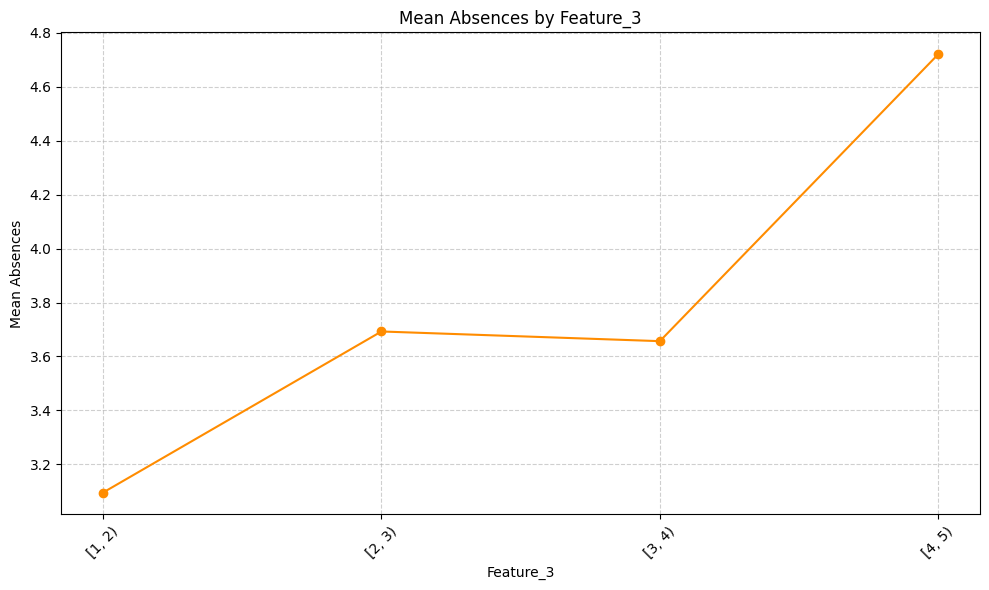

In [65]:
df_temp = df.copy()

bins = np.arange(1, 5, 1)
bins = np.append(bins, 5)

df_temp['Feature_3_bin'] = pd.cut(df_temp['Feature_3'], bins=bins, right=False, include_lowest=True)

# Calculating mean of absences for each bin
mean_absences = df_temp.groupby('Feature_3_bin')['absences'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(mean_absences['Feature_3_bin'].astype(str), mean_absences['absences'],
         marker='o', linestyle='-', color='darkorange')

plt.title('Mean Absences by Feature_3')
plt.xlabel('Feature_3')
plt.ylabel('Mean Absences')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


<ipython-input-66-89d2b666c502>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_feature_2 = df_temp.groupby('Feature_3_bin')['Feature_2'].mean().reset_index()


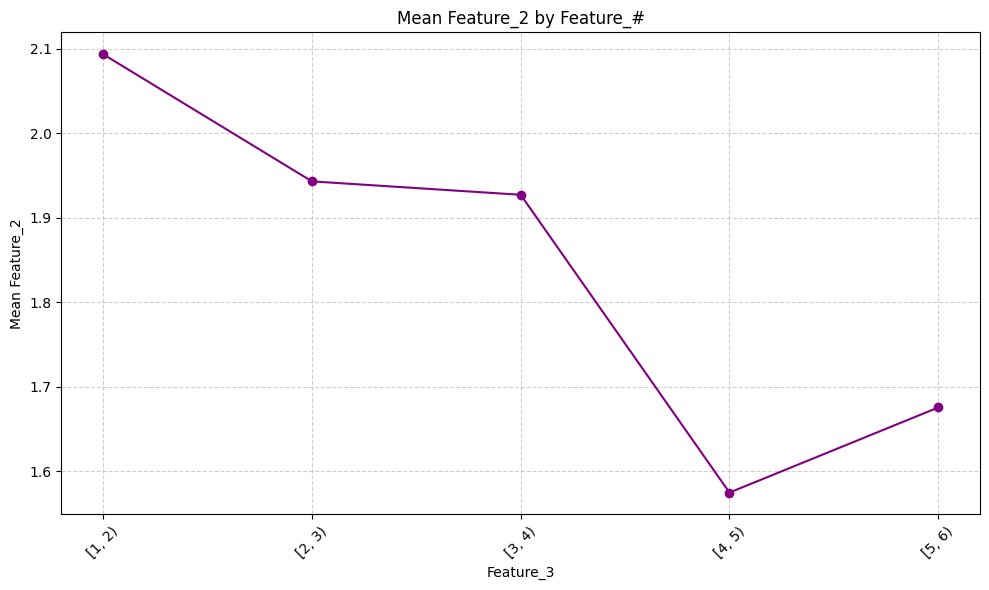

In [66]:
df_temp = df.copy()

bins = np.arange(1, 6, 1)

bins = np.append(bins, 6)

df_temp['Feature_3_bin'] = pd.cut(df_temp['Feature_3'], bins=bins, right=False, include_lowest=True)

# Calculating mean of Feature_2 for each bin
mean_feature_2 = df_temp.groupby('Feature_3_bin')['Feature_2'].mean().reset_index()

# Plot line chart
plt.figure(figsize=(10, 6))
plt.plot(mean_feature_2['Feature_3_bin'].astype(str), mean_feature_2['Feature_2'],
         marker='o', linestyle='-', color='purple')

plt.title('Mean Feature_2 by Feature_#')
plt.xlabel('Feature_3')
plt.ylabel('Mean Feature_2')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


<ipython-input-67-99bc42ee87a9>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_feature_2 = df_temp.groupby('Feature_3_bin')['avg_grade'].mean().reset_index()


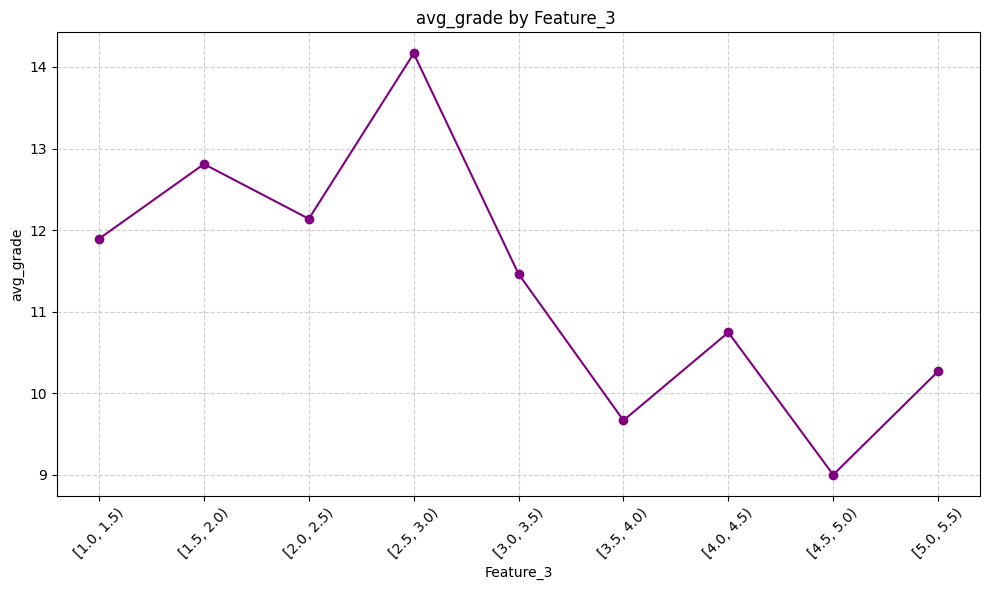

In [67]:
df_temp = df.copy()

bins = np.arange(1, 6, 0.5)
bins = np.append(bins, 6)

df_temp['Feature_3_bin'] = pd.cut(df_temp['Feature_3'], bins=bins, right=False, include_lowest=True)

# Calculating mean of Feature_2 for each bin
mean_feature_2 = df_temp.groupby('Feature_3_bin')['avg_grade'].mean().reset_index()


plt.figure(figsize=(10, 6))
plt.plot(mean_feature_2['Feature_3_bin'].astype(str), mean_feature_2['avg_grade'],
         marker='o', linestyle='-', color='purple')

plt.title('avg_grade by Feature_3 ')
plt.xlabel('Feature_3')
plt.ylabel('avg_grade')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


    ANALYSIS:
    When F3 is higher:

        Students drink more on weekdays (Dalc high) — this usually means more social or less disciplined.

        They go out more often with friends (goout high) — spending time outside school, socializing.

        They have more free time after school (freetime high) — possibly less homework or less study time.

        They are absent from school more (absences high) — missing classes, maybe skipping or being less serious.

    When F3 is lower:

        Students have higher Feature_2 values — which may be study hours or effort put into studies.

        Their average grades (avg_grade) are higher — meaning they are doing well academically.

        They have school support (schoolsup) — extra help that usually improves focus and performance.

What Does This Mean?<br>
PREDICTION

    High F3 students probably spend more time on social activities and less on schoolwork. They might be the ones who enjoy hanging out with friends, going to parties, or relaxing more. This might lead to more absences and lower academic focus.

    Low F3 students are more focused on studying and school. They might spend more time on homework, attend classes regularly, get good grades, and get help when needed. Their social activities and distractions are probably lower.


In [68]:
null_col=df.isnull().sum()
null_col=null_col[null_col>0]
null_col

,0


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 576 entries, 0 to 648
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   school           576 non-null    float64 
 1   sex              576 non-null    int64   
 2   address          576 non-null    int64   
 3   famsize          576 non-null    int64   
 4   Pstatus          576 non-null    int64   
 5   Medu             576 non-null    int64   
 6   Fedu             576 non-null    float64 
 7   Mjob             576 non-null    int64   
 8   Fjob             576 non-null    int64   
 9   reason           576 non-null    int64   
 10  traveltime       576 non-null    float64 
 11  failures         576 non-null    int64   
 12  schoolsup        576 non-null    int64   
 13  famsup           576 non-null    int64   
 14  paid             576 non-null    int64   
 15  activities       576 non-null    int64   
 16  nursery          576 non-null    int64   
 17  hi

In [70]:
df.drop(['age_bin'],axis=1,inplace=True)

<ipython-input-70-667f1ab769cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['age_bin'],axis=1,inplace=True)


# Logistic Regression

In [71]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb

X = df.drop(columns=['romantic'])
y = df['romantic']
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'model__C': [0.01, 0.1, 1, 10],
            'model__solver': ['liblinear', 'lbfgs']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5]
        }
    },
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf'],
            'model__gamma': ['scale', 'auto']
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [3, 5, 7],
            'model__learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(random_state=42),
        'params': {
            'model__n_estimators': [50, 100],
            'model__num_leaves': [31, 50],
            'model__learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}
    }
}
results = {}

for name, mp in models.items():
    print(f"\nTraining and tuning {name}...")

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', mp['model'])
    ])

    if mp['params']:  # If model has hyperparameters
        gs = GridSearchCV(pipe, mp['params'], cv=5, scoring='accuracy', n_jobs=-1)
    else:
        # No GridSearch for models like Naive Bayes
        gs = pipe
    if mp['params']:
        gs.fit(X_train, y_train)
        best_model = gs.best_estimator_
    else:
        gs.fit(X_train, y_train)
        best_model = gs

    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"Test accuracy for {name}: {acc:.4f}")
    if mp['params']:
        print(f"Best parameters for {name}: {gs.best_params_}")
    print(f"Classification report for {name}:\n{classification_report(y_test, y_pred)}")

    results[name] = {'best_model': best_model, 'accuracy': acc}

# Find best model overall
best_algo = max(results, key=lambda k: results[k]['accuracy'])
print(f"\nBest model is **{best_algo}** with accuracy {results[best_algo]['accuracy']:.4f}")

# Print weights/feature importances for best model
print(f"\n Feature Importance or Coefficients for: {best_algo}")
best_model = results[best_algo]['best_model']
model = best_model.named_steps['model']

if hasattr(model, 'feature_importances_'):
    # Tree-based models
    importances = model.feature_importances_
    feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    print(feature_importance)
elif hasattr(model, 'coef_'):
    # Linear models
    coefs = model.coef_[0] if len(model.coef_.shape) > 1 else model.coef_
    feature_importance = pd.Series(coefs, index=X.columns).sort_values(key=abs, ascending=False)
    print(feature_importance)
else:
    print("Naive Bias does not support direct corelation with feature and their weights")



Training and tuning Logistic Regression...
Test accuracy for Logistic Regression: 0.6897
Best parameters for Logistic Regression: {'model__C': 0.1, 'model__solver': 'lbfgs'}
Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.70      0.89      0.78        72
           1       0.67      0.36      0.47        44

    accuracy                           0.69       116
   macro avg       0.68      0.63      0.63       116
weighted avg       0.68      0.69      0.66       116


Training and tuning Random Forest...
Test accuracy for Random Forest: 0.7155
Best parameters for Random Forest: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.71      0.93      0.80        72
           1       0.76      0.36      0.49        44

    accuracy                           0.72      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost/c

Test accuracy for XGBoost: 0.6207
Best parameters for XGBoost: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 50}
Classification report for XGBoost:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        72
           1       0.00      0.00      0.00        44

    accuracy                           0.62       116
   macro avg       0.31      0.50      0.38       116
weighted avg       0.39      0.62      0.48       116


Training and tuning LightGBM...
[LightGBM] [Info] Number of positive: 173, number of negative: 287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 209
[LightGBM] [Info] Number of data points in the train set: 460, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: p

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:57:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 173, number of negative: 287
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 308
[LightGBM] [Info] Number of data points in the train set: 460, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376087 -> initscore=-0.506191
[LightGBM] [Info] Start training from score -0.506191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

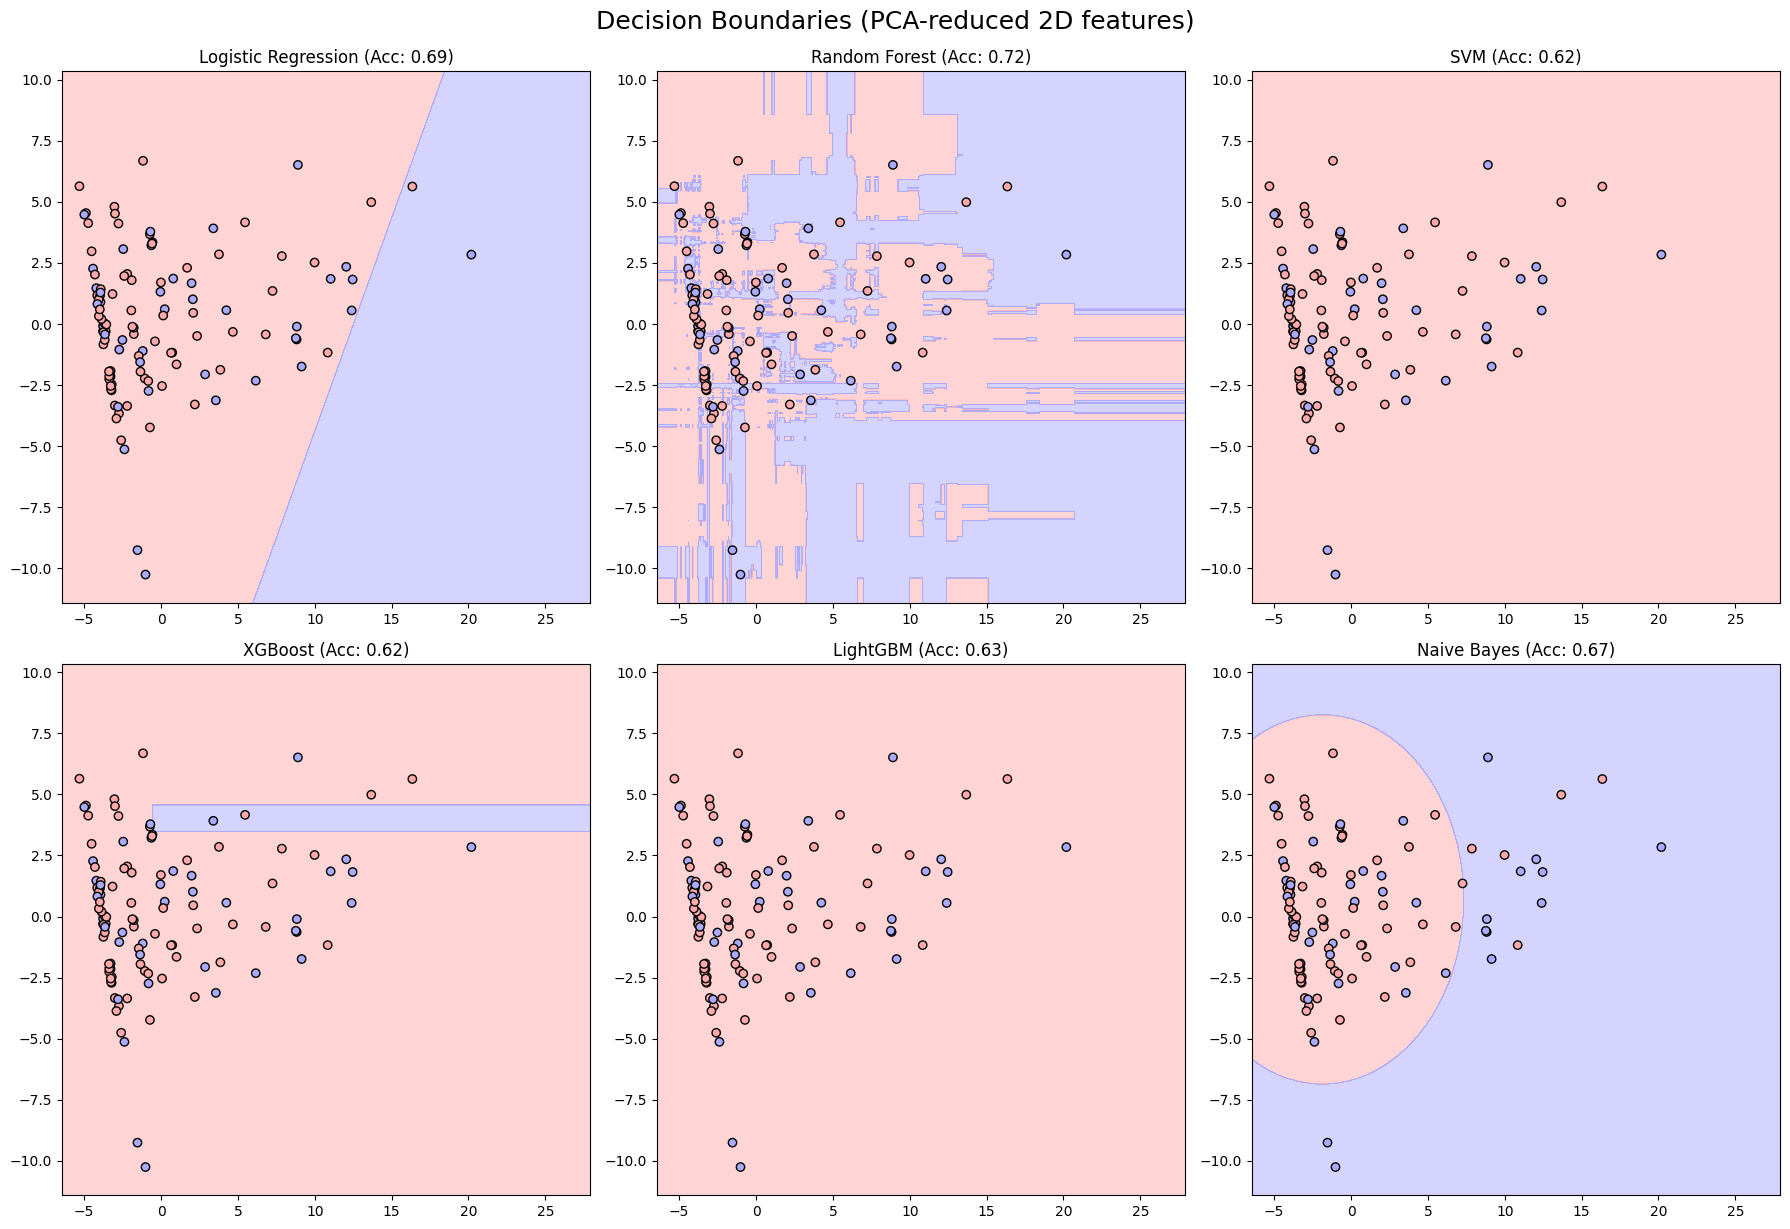

In [72]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train)
X_test_2D = pca.transform(X_test)


x_min, x_max = X_train_2D[:, 0].min() - 1, X_train_2D[:, 0].max() + 1
y_min, y_max = X_train_2D[:, 1].min() - 1, X_train_2D[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Plot decision boundary for each model
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()
cmap = ListedColormap(['#FFAAAA', '#AAAAFF'])

for idx, (name, info) in enumerate(results.items()):
    model = info['best_model']
    model_2D = Pipeline([
        ('model', model.named_steps['model'])
    ])


    model_2D.fit(X_train_2D, y_train)
    Z = model_2D.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axes[idx].contourf(xx, yy, Z, alpha=0.5, cmap=cmap)
    axes[idx].scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=y_test, edgecolor='k', cmap=cmap)
    axes[idx].set_title(f"{name} (Acc: {info['accuracy']:.2f})")
if len(results) < 6:
    for i in range(len(results), 6):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle("Decision Boundaries (PCA-reduced 2D features)", fontsize=18, y=1.02)
plt.show()

In [73]:
import shap


In [74]:
feature_importance = feature_importance.sort_values(ascending=False)
top_10_features = feature_importance.head(10)
print(top_10_features)

avg_grade    0.092936
absences     0.069653
Feature_1    0.062538
Feature_2    0.049162
freetime     0.046168
Fedu         0.044846
goout        0.044403
Feature_3    0.044130
famrel       0.042715
health       0.042244
dtype: float64


These are top 10 features that affect relationship
<b> : Analysing each  

In [75]:
for col in top_10_features.index:
    df.groupby("romantic")[col].agg(["mean","median"])
    print(df.groupby("romantic")[col].agg(["mean","median"]))

               mean     median
romantic                      
0         11.799752  11.666667
1         11.330773  11.333333
              mean    median
romantic                    
0         3.340761  2.000000
1         4.350230  2.333333
               mean  median
romantic                   
0         16.528319    16.0
1         17.035330    17.0
              mean  median
romantic                  
0         1.901578     2.0
1         1.973886     2.0
              mean  median
romantic                  
0         3.215413     3.0
1         3.224270     3.0
              mean  median
romantic                  
0         2.353760     2.0
1         2.221198     2.0
              mean  median
romantic                  
0         3.203343     3.0
1         3.207373     3.0
              mean  median
romantic                  
0         2.314763     2.0
1         2.250384     2.0
              mean  median
romantic                  
0         3.986072     4.0
1         3.861751     4.0


## How Different Things Affect Whether Students Relationship

After looking at the data, here’s what stands out about which students are more likely to be in a relationship:

- **Grades (Avg_grade):**  
  Students who don’t get top marks—so, those with average or even poor grades—seem to be in relationships more often than the straight-A students.

- **Skipping Classes (Absences):**  
  If you’re someone who misses class a lot, you’re more likely to be dating compared to students who always show up.

- **Feature_1 & Feature_2:**  
  The lower these numbers are for a student, the more likely they are to be in a relationship. (Think of it as: less of Feature_1 or Feature_2, more chance of dating.)

- **Free Time:**  
  It’s pretty simple: the more free time you have, the more likely you are to be in a relationship. Maybe it’s just easier to meet people or hang out.

- **Dad’s Education (Fedu):**  
  If your dad has studied a lot, you might be less likely to be in a relationship while you’re a student. One guess is that dads who went far in school encourage their kids to focus on studies first.

- **Going Out with Friends (goout):**  
  Students who go out more often with their friends have a slightly higher chance of being in a relationship.  

- **Feature_3:**  
  Having a lower value here seems to make being in a relationship less likely.  

- **Family Relationships (famrel):**  
  If things aren’t great at home or you don’t get along so well with your family, you might be more likely to find romance elsewhere.  

---

### In Everyday Words

- If you’re not super focused on grades, skip class sometimes, have plenty of free time, like to go out, or don’t always get along with your family, you’re more likely to be dating.
- On the flip side, if your dad is really well-educated, you might hear more about focusing on school instead of relationships.

**All in all, these are just patterns—everyone’s different! But it’s interesting to see what might make students more likely to be in a relationship.**


**Here Are some Interesting Points/Questions that can be answered**

Q1: Can we create features to track student progress and find what makes a top student?

Q2. Does parental education level (Medu, Fedu) influence a student's ambition or performance?<br>


Q3. Who has better grades: students supported by family (famsup) or school (schoolsup)?

Q4: How do early education, internet access, and motivation for school choice affect student performance?

Q5: How do address type, family size, and family relationship quality impact student performance and well-being(Social activities)?

Ans 1:Yes! We can calculate the average of early grades (G1 and G2) to see how a student is doing overall. We can also track how their grades change over time — whether they’re improving or slipping.

When we look at students who score high in the final grade (G3 ≥ 15), they often share some common traits:

They went to nursery school

They have internet at home

They chose their school for learning, not just location

Their parents are educated and family life is good

They balance study and fun — not too much partying, not too much stress

This helps us understand what kind of background and habits lead to success.

In [76]:
df.head()

,school,sex,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,traveltime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,famrel,freetime,goout,Dalc,health,absences,Feature_1,Feature_2,Feature_3,romantic,gaurdian_mother,gaurdian_other,avg_grade
0,0.651772,1,1,4,0,4,4.0,1,5,2,2.000000,0,1,0,0,0,1,1.0,0,4,3.0,4,1,3,4.0,18.0,2.000000,1.0,0,1,0,7.333333
1,0.651772,1,1,4,1,1,1.0,1,2,2,1.333333,0,0,1,0,0,0,1.0,1,5,3.0,3,1,3,2.0,17.0,2.000000,1.0,0,0,0,10.333333
2,0.651772,1,1,2,1,1,1.0,1,2,1,1.000000,0,1,0,0,0,1,1.0,1,4,3.0,2,2,3,6.0,15.0,1.666667,3.0,0,1,0,12.333333
3,0.651772,1,1,4,1,4,2.0,4,3,3,1.000000,0,0,1,0,1,1,1.0,1,3,2.0,2,1,5,0.0,15.0,3.000000,1.0,1,1,0,14.000000
4,0.651772,1,1,4,1,3,3.0,2,2,3,1.000000,0,0,1,0,0,1,1.0,0,4,3.0,2,1,5,0.0,16.0,2.000000,2.0,0,0,0,12.333333


In [78]:
# ANS2:
df_temp=df.copy()
df_temp['P_edu']=df_temp['Fedu']+df_temp['Medu']
df_temp.groupby('P_edu')['higher'].value_counts()

P_edu  higher  
0.0    1.000000     1
1.0    1.000000     5
       0.000000     1
2.0    1.000000    71
       0.000000    15
       0.333333     1
3.0    1.000000    58
       0.000000    16
       0.666667     3
4.0    1.000000    98
       0.000000    15
       0.666667     3
5.0    1.000000    59
       0.000000     7
       0.666667     1
6.0    1.000000    74
       0.000000     3
       0.666667     2
7.0    1.000000    55
       0.333333     1
       0.666667     1
8.0    1.000000    84
       0.000000     2
Name: count, dtype: int64

In [79]:
df_temp.groupby('P_edu')['avg_grade'].mean()

,avg_grade
P_edu,
0.0,10.666667
1.0,10.388889
2.0,10.535121
3.0,11.020202
4.0,11.217433
5.0,11.527363
6.0,12.253165
7.0,12.413255
8.0,12.879845


In [83]:
# ANS3
df_temp=df.copy()
df_temp.groupby(['schoolsup','famsup'])['avg_grade'].mean()

schoolsup  famsup
0          0         11.591534
           1         11.775578
1          0         10.209877
           1         11.308642
Name: avg_grade, dtype: float64

Famsup student are slightly better in acads

In [84]:
df_temp.groupby(['internet','school','nursery'])['avg_grade'].mean()

internet  school    nursery
0         0.348228  0          10.712963
                    1           9.975309
          0.651772  0          11.311111
                    1          11.898765
1         0.348228  0          11.080460
                    1          10.918889
          0.651772  0          11.928571
                    1          12.310764
Name: avg_grade, dtype: float64

Nursey education does not have much effect on grade but internet and school selection has:As<br>
1: GP students out performs MS <br>
2:Students with internet access tend to perform better than those without it.